# Predicting of contestation building cadastre cost (ver. 4)

In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import os
import pickle
#import multiprocessing
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.grid_search import GridSearchCV
import seaborn
import catboost
import shap

#if LINUX, set var:
#os.environ['NLS_LANG'] = 'RUSSIAN_CIS.CL8MSWIN1251'

#if need upload to Oracle float numbers with ',' separator
os.environ['NLS_LANG'] = 'AMERICAN_AMERICA.CL8MSWIN1251'

import cx_Oracle
print(cx_Oracle.version)
print(os.environ)

# set full window wide cells (only in this notebook)
from IPython.core.display import display, HTML, display_html
display(HTML("<style>.container { width:99% !important; }</style>")) 

# Display some dataframes in one cell from left to right 
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

/root/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/root/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


6.4.1
environ({'LANG': 'ru_RU.UTF-8', 'LANGUAGE': 'ru_RU.utf8', 'LC_NUMERIC': 'en_US.UTF-8', 'PATH': '/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin', 'HOME': '/root', 'LOGNAME': 'root', 'USER': 'root', 'SHELL': '/bin/sh', 'INVOCATION_ID': '0dc28828327743918bfbfb63d9a577d2', 'JOURNAL_STREAM': '8:21969', 'BEAKERX_AUTOTRANSLATION_PASSWORD': 'DuyPcrLpa1WpRH38aSAtlHtA94nfx8FDS4grwmGcXrnIHxfoNyrK8gcOdTM59affmwWb10MQal4y3PYP6dphjuQcq1iDInjMM1oL6XZ9jnnMjRYGAELi1YdON4VURLgY', 'BEAKERX_AUTOTRANSLATION_PORT': '33043', 'JPY_PARENT_PID': '753', 'TERM': 'xterm-color', 'CLICOLOR': '1', 'PAGER': 'cat', 'GIT_PAGER': 'cat', 'MPLBACKEND': 'module://ipykernel.pylab.backend_inline', 'NLS_LANG': 'AMERICAN_AMERICA.CL8MSWIN1251'})


In [2]:
#Print all pandas dataframes in ONE Cell!!!
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 220)
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:,.2f}'.format)

## FUNCTIONS

In [4]:
#dump_date = '20181106'
dump_date = '20181210'

In [5]:
def sql_load(df, df_col, db, db_col):
    print('To load by df col:', len(df))
    split=800# Oracle one request limit about 1000-1200 symbols
    connection = cx_Oracle.connect('...')
    #EXTRACT(YEAR FROM b.REG_NUMR_DTCR)
    for i in np.arange(0, len(df), split):
        df_sql = pd.read_sql(sql='''select * 
        from '''+db+''' where '''+db_col+''' in ('''+str(list(df[df_col][i:i+split].values))[1:-1]+''')''', con=connection) #[1:-1]  to remove  ''
        if i != 0: 
            df_sum = pd.concat([df_sum, df_sql])
            print('L:',i,'-',i+split, end='  ')
        else:
            df_sum = df_sql.copy()
            print('L:',i,'-',i+split, end='  ')
    connection.close()
    print('\nLoaded summary:', len(df_sum))
    df_sum = df_sum.reset_index(drop=True)
    return df_sum

## DATA LOADING AND PREPARING

In [244]:
#Commissions
df = pd.read_excel('/mnt/Z/УБД/Кадастровая оценка/Оспаривание/Оспаривания_копия.xlsx', sheet_name='Комиссия', skiprows=[1])#, header=[0,1])
df.columns = ['n','cadnum','type','naz','prot','date_act','resh','resh_osnov','cad_cost','new_cost','date_z','change_cost','change_pr','area','cadnum_build','p15','p16','p17','p18','p19','p20','date_o','date_prim']
df = df[['cadnum','cad_cost','new_cost','change_pr','change_cost','type','area','p16','p17','p18','p19','date_act','date_o','date_prim']]
df['org'] = 0
display_side_by_side(df.head(3), df.tail(3))
df_commis = df.copy()

,cadnum,cad_cost,new_cost,change_pr,change_cost,type,area,p16,p17,p18,p19,date_act,date_o,date_prim,org
0,77:01:0003047:1017,"1,417,661,641.11",961377000,-0.32,"-456,284,641.11",Здание,"13,171.70",да,да,да,да,2016-01-12 00:00:00,2014-01-01,2015-01-01,0
1,77:03:0003008:1016,"584,488,640.34","584,488,640.34",0.00,0.00,Здание,"6,200.30",да,да,да,да,2016-01-12 00:00:00,2014-01-01,2016-01-01,0
2,77:01:0006017:1010,"1,475,299,971.61","1,475,299,971.61",0.00,0.00,Здание,"9,560.50",да,да,да,да,2016-01-12 00:00:00,2014-01-01,2016-01-01,0
,cadnum,cad_cost,new_cost,change_pr,change_cost,type,area,p16,p17,p18,p19,date_act,date_o,date_prim,org
26197,77:01:0003007:3355,"27,432,243.91","27,432,243.91",0.00,0.00,Помещение,159.50,да,да,да,да,15.01.2019,2016-01-01,2018-01-01,0
26198,77:01:0003007:3359,"6,561,514.58","6,561,514.58",0.00,0.00,Помещение,35.30,да,да,да,да,15.01.2019,2016-01-01,2018-01-01,0
26199,77:06:0004009:5125,"32,580,014.74",21456000,-0.34,"-11,124,014.74",Помещение,223.70,да,да,да,да,15.01.2019,2016-01-01,2018-01-01,0


#TEST
display_side_by_side(df[df.duplicated('cadnum', keep=False)].sort_values(by=['cadnum']))
len(df[df.duplicated('cadnum', keep=False)].sort_values(by=['cadnum']))

In [57]:
#Courts
df = pd.read_excel('/mnt/Z/УБД/Кадастровая оценка/Оспаривание/Оспаривания_копия.xlsx', sheet_name='Суд', skiprows=[1])
df.columns = ['n','delo','istec','date_act','cadnum','cad_cost','new_cost','change_pr','change_cost','type','area','p15','p16','p17','p18','p19','date_o','date_prim']
df = df[['cadnum','cad_cost','new_cost','change_pr','change_cost','type','area','p16','p17','p18','p19','date_act','date_o','date_prim']]
df['org'] = 1
display_side_by_side(df.head(3), df.tail(3))
df_court = df.copy()

,cadnum,cad_cost,new_cost,change_pr,change_cost,type,area,p16,p17,p18,p19,date_act,date_o,date_prim,org
0,77:01:0003017:3776,"1,252,101,128.83","781,396,000.00",-0.38,"-470,705,128.83",Помещение,"6,305.10",да,да,да,да,2016-05-13,2013-01-01,2014-01-01,1
1,77:01:0003017:3801,"354,726,391.44","92,908,000.00",-0.74,"-261,818,391.44",Помещение,"1,777.20",да,да,да,да,2016-10-25,2013-01-01,2014-01-01,1
2,77:01:0003017:3803,"45,268,931.79","22,842,000.00",-0.50,"-22,426,931.79",Помещение,226.80,да,да,да,да,2016-10-25,2013-01-01,2014-01-01,1
,cadnum,cad_cost,new_cost,change_pr,change_cost,type,area,p16,p17,p18,p19,date_act,date_o,date_prim,org
9630,77:03:0004012:1020,"553,267,957.34","155,197,000.00",-0.72,"-398,070,957.34",Здание,"4,495.20",да,да,да,да,2017-09-28,2016-01-01,2017-01-01,1
9631,77:05:0004014:1007,"392,825,310.74","207,807,000.00",-0.47,"-185,018,310.74",Здание,"3 030,9",да,да,да,да,2017-12-20,2016-01-01,2017-01-01,1
9632,77:01:0003005:1073,"669,229,955.63","383,784,000.00",-0.43,"-285,445,955.63",Здание,"3,915.80",да,да,да,да,2017-09-08,2016-01-01,2017-01-01,1


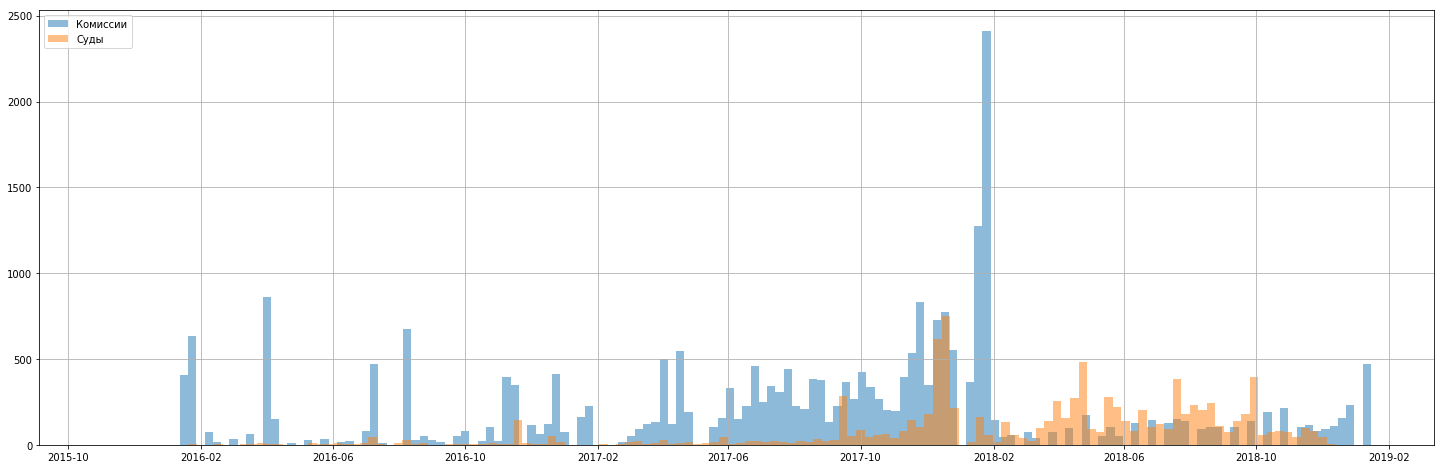

In [258]:
fig, ax = plt.subplots(figsize=(25,8))
plt.hist(pd.to_datetime(df_commis['date_act']), bins=16*3*3, alpha=0.5, label='Комиссии')
plt.hist(pd.to_datetime(df_court['date_act']), bins=16*3*3, alpha=0.5, label='Суды')
ax.grid()
ax.legend(loc='upper left');

#TEST
display_side_by_side(df[df.duplicated('cadnum', keep=False)].sort_values(by=['cadnum']))
len(df[df.duplicated('cadnum', keep=False)].sort_values(by=['cadnum']))

In [453]:
df = pd.concat([df_commis, df_court], sort=False).reset_index(drop=True)
display_side_by_side(df.head(3), df.tail(3))

,cadnum,cad_cost,new_cost,change_pr,change_cost,type,area,p16,p17,p18,p19,date_act,date_o,date_prim,org
0,77:02:0010009:3623,"790,517,129.09",507730000,-0.36,"-282,787,129.09",Здание,"8,094.20",да,да,да,NaN,2016-01-12,2014-01-01,2015-01-01,0
1,77:01:0001093:1094,"1,015,302,509.19","1,015,302,509.19",0.00,0.00,Здание,"5,073.20",да,да,да,NaN,2016-01-12,2014-01-01,2016-01-01,0
2,77:03:0006003:10143,"448,854,208.53",215371643,-0.52,"-233,482,565.53",Помещение,"4,021.30",да,да,да,NaN,2016-01-12,2014-01-01,2015-01-01,0
,cadnum,cad_cost,new_cost,change_pr,change_cost,type,area,p16,p17,p18,p19,date_act,date_o,date_prim,org
34399,77:01:0005001:6037,"30,134,271.97","16,041,000.00",-0.47,"-14,093,271.97",Помещение,107.00,да,да,да,NaN,2017-12-19,2016-01-01,2017-01-01,1
34400,77:01:0006023:5674,"2,878,140.81","1,369,000.00",-0.52,"-1,509,140.81",Помещение,16.10,да,да,да,NaN,2017-12-21,2016-01-01,2017-01-01,1
34401,77:09:0005008:3747,"4,142,930.75","2,468,500.00",-0.40,"-1,674,430.75",Помещение,25.00,да,да,да,NaN,2017-12-21,2016-01-01,2017-01-01,1


In [454]:
def convert_float(val):
    try:
        return float(str(val).replace(',', '.').replace('\xa0', '').replace(' ', '')) # \xa0 is a nonbreaking space, encoded in ISO-8859-1
    except ValueError:
        return np.nan

df['new_cost'] = df['new_cost'].apply(lambda x: convert_float(x))
df['area'] = df['area'].apply(lambda x: convert_float(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34402 entries, 0 to 34401
Data columns (total 15 columns):
cadnum         34402 non-null object
cad_cost       34402 non-null float64
new_cost       34397 non-null float64
change_pr      34397 non-null float64
change_cost    34397 non-null float64
type           34402 non-null object
area           34402 non-null float64
p16            34400 non-null object
p17            34400 non-null object
p18            34400 non-null object
p19            425 non-null object
date_act       34402 non-null datetime64[ns]
date_o         34402 non-null datetime64[ns]
date_prim      34387 non-null datetime64[ns]
org            34402 non-null int64
dtypes: datetime64[ns](3), float64(5), int64(1), object(6)
memory usage: 3.9+ MB


In [455]:
df['date_act'] = df['date_act'].apply(lambda x: str(x.year))
df['date_o'] = df['date_o'].apply(lambda x: str(x.year))
df['date_prim'] = df['date_prim'].apply(lambda x: str(x.year))

df.shape
#df = df[df['change_pr']<0] #Get only who can contestate ('change_pr'<0)
#df.shape
#df = df[df['org']==1] #Get only courts ('org'=1)
#df.shape
df = pd.concat([ df[df['date_o']=='2014'].drop_duplicates('cadnum', keep='last'), df[df['date_o']=='2016'].drop_duplicates('cadnum', keep='last')], sort=False).reset_index(drop=True) #drop dupl. till 2016 and dupl from 2017
df.shape
df_court = df.copy()

(34402, 15)

(23173, 15)

In [411]:
#TEST
df['date_prim'].value_counts()

2017    6950
2018     640
2016     617
2015     392
nan       14
Name: date_prim, dtype: int64

#TEST
display_side_by_side(df[df.duplicated('cadnum', keep=False)].sort_values(by=['cadnum']))
len(df[df.duplicated('cadnum', keep=False)].sort_values(by=['cadnum']))

In [14]:
#TEST
print('2015-2016 years, from', len(df[df['date_o']=='2014']), 'can contestate kommission', len(df[(df['change_cost']<0)&(df['date_o']=='2014')&(df['org']==0)]))
print('2015-2016 years, from', len(df[df['date_o']=='2014']), 'can contestate court', len(df[(df['change_cost']<0)&(df['date_o']=='2014')&(df['org']==1)]))
print('2015-2016 years, from', len(df[df['date_o']=='2014']), 'can not contestate kommission', len(df[(df['change_cost']>=0)&(df['date_o']=='2014')&(df['org']==0)]))
print('2015-2016 years, from', len(df[df['date_o']=='2014']), 'can not contestate court', len(df[(df['change_cost']>=0)&(df['date_o']=='2014')&(df['org']==1)]))
print('2015-2016 years, from', len(df[df['date_o']=='2014']), 'can contestate count', len(df[(df['change_cost']<0)&(df['date_o']=='2014')&(df['org']==0)])+len(df[(df['change_cost']<0)&(df['date_o']=='2014')&(df['org']==1)]))

print('2017-2018 years, from', len(df[df['date_o']=='2016']), 'can contestate kommission', len(df[(df['change_cost']<0)&(df['date_o']=='2016')&(df['org']==0)]))
print('2017-2018 years, from', len(df[df['date_o']=='2016']), 'can contestate court', len(df[(df['change_cost']<0)&(df['date_o']=='2016')&(df['org']==1)]))
print('2017-2018 years, from', len(df[df['date_o']=='2016']), 'can not contestate kommission', len(df[(df['change_cost']>=0)&(df['date_o']=='2016')&(df['org']==0)]))
print('2017-2018 years, from', len(df[df['date_o']=='2016']), 'can not contestate court', len(df[(df['change_cost']>=0)&(df['date_o']=='2016')&(df['org']==1)]))
print('2017-2018 years, from', len(df[df['date_o']=='2016']), 'can contestate count', len(df[(df['change_cost']<0)&(df['date_o']=='2016')&(df['org']==0)])+len(df[(df['change_cost']<0)&(df['date_o']=='2016')&(df['org']==1)]))

2015-2016 years, from 2777 can contestate kommission 1768
2015-2016 years, from 2777 can contestate court 1009
2015-2016 years, from 2777 can not contestate kommission 0
2015-2016 years, from 2777 can not contestate court 0
2015-2016 years, from 2777 can contestate count 2777
2017-2018 years, from 12987 can contestate kommission 5397
2017-2018 years, from 12987 can contestate court 7590
2017-2018 years, from 12987 can not contestate kommission 0
2017-2018 years, from 12987 can not contestate court 0
2017-2018 years, from 12987 can contestate count 12987


In [15]:
#TEST
(df['date_prim'][(df['change_cost']<0)&(df['org']==1)].value_counts().index).sort_values()

Index(['2015', '2016', '2017', '2018'], dtype='object')

In [ ]:
#TEST
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(df['date_prim'][(df['change_cost']>=0)&(df['org']==0)].value_counts().index, df['date_prim'][(df['change_cost']>=0)&(df['org']==0)].value_counts(), .2, align='edge', alpha=.65, label='KOMM decline count')
ax.bar(df['date_prim'][(df['change_cost']<0)&(df['org']==0)].value_counts().index, df['date_prim'][(df['change_cost']<0)&(df['org']==0)].value_counts(), .2, align='edge', alpha=.65, label='KOMM cost down count')
ax.bar(df['date_prim'][(df['change_cost']>=0)&(df['org']==1)].value_counts().index, df['date_prim'][(df['change_cost']>=0)&(df['org']==1)].value_counts(), -.2, align='edge', alpha=.65, label='COURT decline count')
ax.bar(df['date_prim'][(df['change_cost']<0)&(df['org']==1)].value_counts().index, df['date_prim'][(df['change_cost']<0)&(df['org']==1)].value_counts(), -.2, align='edge', alpha=.65, label='COURT cost down count')
ax.grid()
ax.legend(loc='upper left');

## DATA loading:

Оценка выполненная в 2014 году, действует в 2015 и 2016 году - GKO_2014 (CAD_COST_20150101)

Оценка выполненная в 2016, действует в 2017 и 2018 году - GKO_2016 (AM_GKO2)

Оценка выполненная в 2018, действует в 2019 и 2020 году - GKO_2018 (T_GKO_2018)
Комиссии по запросам на пересмотр кадастровой стоимости с 2019 года отменены, все запросы на оспаривания будут приниматься через суды.

Перечень объектов для налогообожения в 2016 году - AM_F16

Перечень объектов для налогообожения в 2017 году - AM_F17

Перечень объектов для налогообожения в 2018 году - AM_F18

Перечень объектов для налогообожения в 2019 году - AM_F19

Правообладатели - AV_EGRP_20181001 (key NUM_CADNUM select NAME, INN where REG_CLOSE_REGNUM = 0)

In [13]:
%%time
# Load perechen lists 2016-2018
connection = cx_Oracle.connect('READ_USER/READ_USER@172.16.108.27:1521/jobdbp_1')

df_am_f16 = pd.read_sql(sql='''select p.CADNUM 
from AM_F16 p 
order by p.CADNUM''', con=connection)
#df_am_f17 = pd.read_sql(sql='''select p.CADNUM 
#from AM_F17 p 
#order by p.CADNUM''', con=connection)
df_am_f18 = pd.read_sql(sql='''select p.CADNUM 
from AM_F18 p 
order by p.CADNUM''', con=connection)

connection.close()
#display_side_by_side(df_am_f16.head(), df_am_f16.tail(), df_am_f17.head(), df_am_f17.tail(), df_am_f18.head(), df_am_f18.tail())
display_side_by_side(df_am_f16.head(), df_am_f16.tail(), df_am_f18.head(), df_am_f18.tail())

,CADNUM
0,50:20:0020106:1046
1,50:20:0020106:1051
2,50:20:0020106:1067
3,50:20:0020106:1069
4,50:20:0020106:726
,CADNUM
372612,77:22:0030118:578
372613,77:22:0030118:579
372614,77:22:0030302:133
372615,77:22:0030306:37


CPU times: user 2.83 s, sys: 796 ms, total: 3.62 s
Wall time: 51 s


In [413]:
%%time
# Load realty in perechen 2019

connection = cx_Oracle.connect('READ_USER/READ_USER@172.16.108.27:1521/jobdbp_1')
df_gko2016 = pd.read_sql(sql='''
select 
p.*, 
o.AREA as AREA_16, t.AREA as AREA_18, 
o.GROUP_NAME as GR_NAME_16, t.GROUP_NAME as GR_NAME_18, 
o.GROUP_NUMBER as GROUP_16, t.GROUP_NUMBER as GROUP_18, 
c.CADCOST as OCENKA_14, o.CADCOST as OCENKA_16, t.CADCOST as OCENKA_18, 
e.REG_CLOSE_REGDT, e.OWNERTP_CD, e.NAME, e.INN, e2.CODEOKVED, r1.AO2 as AO2_B, r2.AO2 as AO2_P, r3.AO2 as AO2_F, r1.EXPCHAR_YEARBUILD as YEAR_BUILD 
    from AM_F19 p 
left join GKO_2014 c 
    on c.CADNUM = p.CADNUM 
left join GKO_2016 o 
    on o.CADNUM = p.CADNUM 
left join GKO_2018 t 
    on t.CADNUM = p.CADNUM 
left join AV_EGRP_'''+dump_date+''' e 
    on e.NUM_CADNUM = p.CADNUM 
left join EGRUL_IMPORT.EGRUL_UL e1 
    on e1.INN = e.INN 
left join EGRUL_IMPORT.EGRUL_OKVED e2 
    on e2.UL_ID = e1.ID 

left join DK_V_BUILDING_'''+dump_date+''' r1 
    on r1.REALTY_ID = p.CADNUM 
left join DK_V_PARCEL_'''+dump_date+''' r2 
    on r2.CADNUM = p.CADNUM 
left join DK_V_FLAT_'''+dump_date+''' r3 
    on r3.REALTY_ID = p.CADNUM 

order by p.CADNUM''', con=connection)
connection.close()

display_side_by_side(df_gko2016.head(3), df_gko2016.tail(3))

,CADNUM,AREA_16,AREA_18,GR_NAME_16,GR_NAME_18,GROUP_16,GROUP_18,OCENKA_14,OCENKA_16,OCENKA_18,REG_CLOSE_REGDT,OWNERTP_CD,NAME,INN,CODEOKVED,AO2_B,AO2_P,AO2_F,YEAR_BUILD
0,50:09:0000000:179835,nan,nan,None,None,None,None,nan,nan,nan,2017-03-23 00:00:00,10,Физическое лицо,None,None,Неопределено,None,None,2011
1,50:09:0000000:179835,nan,nan,None,None,None,None,nan,nan,nan,2017-03-23 00:00:00,20,"Общество с ограниченной ответственностью ""Харита плюс""",5044034849,68.20,Неопределено,None,None,2011
2,50:09:0000000:179835,nan,nan,None,None,None,None,nan,nan,nan,2017-03-23 00:00:00,20,"Общество с ограниченной ответственностью ""Харита плюс""",5044034849,68.20,Неопределено,None,None,2011
,CADNUM,AREA_16,AREA_18,GR_NAME_16,GR_NAME_18,GROUP_16,GROUP_18,OCENKA_14,OCENKA_16,OCENKA_18,REG_CLOSE_REGDT,OWNERTP_CD,NAME,INN,CODEOKVED,AO2_B,AO2_P,AO2_F,YEAR_BUILD
1192771,77:22:0040110:249,nan,406.70,None,"4.2 Объекты торговли, общественного питания, бытового обслуживания, сервиса, отдыха и развлечений, включая объекты многофункционального назначения (дополнительная территория)",None,4,nan,nan,"8,865,580.09",2017-09-04 00:00:00,20,"Потребительский кооператив ""Подольское городское потребительское общество""",5036102750,68.2,Роговское,None,None,2016
1192772,77:22:0040110:249,nan,406.70,None,"4.2 Объекты торговли, общественного питания, бытового обслуживания, сервиса, отдыха и развлечений, включая объекты многофункционального назначения (дополнительная территория)",None,4,nan,nan,"8,865,580.09",2017-09-04 00:00:00,20,"Потребительский кооператив ""Подольское городское потребительское общество""",5036102750,68.2,Роговское,None,None,2016
1192773,77:22:0040110:249,nan,406.70,None,"4.2 Объекты торговли, общественного питания, бытового обслуживания, сервиса, отдыха и развлечений, включая объекты многофункционального назначения (дополнительная территория)",None,4,nan,nan,"8,865,580.09",2017-09-04 00:00:00,20,"Потребительский кооператив ""Подольское городское потребительское общество""",5036102750,68.2,Роговское,None,None,2016


CPU times: user 53.4 s, sys: 4.24 s, total: 57.6 s
Wall time: 3min 28s


In [414]:
len(df_gko2016)
df_gko2016 = df_gko2016.drop_duplicates().reset_index(drop=True)
len(df_gko2016)

1192774

593980

In [415]:
df_gko2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593980 entries, 0 to 593979
Data columns (total 19 columns):
CADNUM             593980 non-null object
AREA_16            524154 non-null float64
AREA_18            543831 non-null float64
GR_NAME_16         524154 non-null object
GR_NAME_18         543831 non-null object
GROUP_16           524154 non-null object
GROUP_18           543831 non-null object
OCENKA_14          413708 non-null float64
OCENKA_16          524154 non-null float64
OCENKA_18          543831 non-null float64
REG_CLOSE_REGDT    129661 non-null object
OWNERTP_CD         300745 non-null object
NAME               300745 non-null object
INN                152388 non-null object
CODEOKVED          131974 non-null object
AO2_B              51029 non-null object
AO2_P              0 non-null object
AO2_F              542951 non-null object
YEAR_BUILD         47391 non-null object
dtypes: float64(5), object(14)
memory usage: 86.1+ MB


In [416]:
# Convert str(mistake) to float
#df_gko2016['AREA_16'] = df_gko2016['AREA_16'].str.replace(',','.').astype(float)
#df_gko2016['OCENKA_16'] = df_gko2016['OCENKA_16'].str.replace(',','.').astype(float)
df_gko2016['GR_NAME_18'] = df_gko2016['GR_NAME_18'].str.replace('\r','')

df_gko2016[:200][df_gko2016['GR_NAME_18'].str.contains('\t')==True]

df_gko2016['GR_NAME_18'].value_counts()

df_gko2016['GR_NAME_18'] = df_gko2016['GR_NAME_18'].str.replace('\r','')

df_gko2016_no_fiz = df_gko2016[df_gko2016['NAME']!='Физическое лицо']
print(df_gko2016_no_fiz.shape)

In [417]:
#WRITE!
df_gko2016.to_csv('//home/df_gko2016_'+dump_date+'.csv', sep='\t', index=False)

In [456]:




#READ
df_gko2016 = pd.read_csv('//home/df_gko2016_'+dump_date+'.csv', sep='\t')
print(df_gko2016.shape) 
display_side_by_side(df_gko2016.head(3), df_gko2016.tail(3))

(593980, 19)


,CADNUM,AREA_16,AREA_18,GR_NAME_16,GR_NAME_18,GROUP_16,GROUP_18,OCENKA_14,OCENKA_16,OCENKA_18,REG_CLOSE_REGDT,OWNERTP_CD,NAME,INN,CODEOKVED,AO2_B,AO2_P,AO2_F,YEAR_BUILD
0,50:09:0000000:179835,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,2017-03-23 00:00:00,10.00,Физическое лицо,nan,NaN,Неопределено,nan,NaN,"2,011.00"
1,50:09:0000000:179835,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,2017-03-23 00:00:00,20.00,"Общество с ограниченной ответственностью ""Харита плюс""","5,044,034,849.00",68.20,Неопределено,nan,NaN,"2,011.00"
2,50:09:0000000:185232,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,NaN,nan,NaN,nan,NaN,NaN,nan,Неопределено,nan
,CADNUM,AREA_16,AREA_18,GR_NAME_16,GR_NAME_18,GROUP_16,GROUP_18,OCENKA_14,OCENKA_16,OCENKA_18,REG_CLOSE_REGDT,OWNERTP_CD,NAME,INN,CODEOKVED,AO2_B,AO2_P,AO2_F,YEAR_BUILD
593977,77:22:0040110:24,135.60,135.60,5.2 Дополнительная территория,"4.2 Объекты торговли, общественного питания, бытового обслуживания, сервиса, отдыха и развлечений, включая объекты многофункционального назначения (дополнительная территория)",5.00,4.00,"1,676,750.95","1,796,925.10","3,020,319.14",NaN,10.00,Физическое лицо,nan,NaN,Первомайское,nan,NaN,"2,008.00"
593978,77:22:0040110:249,nan,406.70,NaN,"4.2 Объекты торговли, общественного питания, бытового обслуживания, сервиса, отдыха и развлечений, включая объекты многофункционального назначения (дополнительная территория)",nan,4.00,nan,nan,"8,865,580.09",NaN,10.00,Физическое лицо,nan,NaN,Роговское,nan,NaN,"2,016.00"
593979,77:22:0040110:249,nan,406.70,NaN,"4.2 Объекты торговли, общественного питания, бытового обслуживания, сервиса, отдыха и развлечений, включая объекты многофункционального назначения (дополнительная территория)",nan,4.00,nan,nan,"8,865,580.09",2017-09-04 00:00:00,20.00,"Потребительский кооператив ""Подольское городское потребительское общество""","5,036,102,750.00",68.2,Роговское,nan,NaN,"2,016.00"


In [457]:
#df_gko2016[df_gko2016['AO2_B'].isna() & df_gko2016['AO2_P'].isna() & df_gko2016['AO2_F'].isna()].head() #TEST

In [458]:
#TEST
len(df_gko2016[df_gko2016['AO2_B'].notna()]), len(df_gko2016[df_gko2016['AO2_P'].notna()]), len(df_gko2016[df_gko2016['AO2_F'].notna()]) #TEST

(51029, 0, 542951)

In [459]:
# Union data from 3 columns to one via dropna()
df_gko2016['AO2'] = pd.concat([df_gko2016['AO2_B'], df_gko2016['AO2_P'], df_gko2016['AO2_F']]).dropna()
# Create 
df_gko2016['TYPE'] = df_gko2016.apply(lambda row: 'BUILDING' if pd.notna(row['AO2_B']) else 'PARCEL' if pd.notna(row['AO2_P']) else 'FLAT', axis=1)
display_side_by_side(df_gko2016.head(), df_gko2016.tail())
df_gko2016['TYPE'].value_counts()

,CADNUM,AREA_16,AREA_18,GR_NAME_16,GR_NAME_18,GROUP_16,GROUP_18,OCENKA_14,OCENKA_16,OCENKA_18,REG_CLOSE_REGDT,OWNERTP_CD,NAME,INN,CODEOKVED,AO2_B,AO2_P,AO2_F,YEAR_BUILD,AO2,TYPE
0,50:09:0000000:179835,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,2017-03-23 00:00:00,10.00,Физическое лицо,nan,NaN,Неопределено,nan,NaN,"2,011.00",Неопределено,BUILDING
1,50:09:0000000:179835,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,2017-03-23 00:00:00,20.00,"Общество с ограниченной ответственностью ""Харита плюс""","5,044,034,849.00",68.20,Неопределено,nan,NaN,"2,011.00",Неопределено,BUILDING
2,50:09:0000000:185232,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,NaN,nan,NaN,nan,NaN,NaN,nan,Неопределено,nan,Неопределено,FLAT
3,50:09:0000000:185233,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,NaN,10.00,Физическое лицо,nan,NaN,NaN,nan,Неопределено,nan,Неопределено,FLAT
4,50:09:0000000:185233,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,2017-03-23 00:00:00,10.00,Физическое лицо,nan,NaN,NaN,nan,Неопределено,nan,Неопределено,FLAT
,CADNUM,AREA_16,AREA_18,GR_NAME_16,GR_NAME_18,GROUP_16,GROUP_18,OCENKA_14,OCENKA_16,OCENKA_18,REG_CLOSE_REGDT,OWNERTP_CD,NAME,INN,CODEOKVED,AO2_B,AO2_P,AO2_F,YEAR_BUILD,AO2,TYPE
593975,77:22:0030517:17,"1,228.90","1,228.90",5.3 Объекты с неполными характеристиками,4.3 Объекты с неполными характеристиками,5.00,4.00,"15,195,864.64","29,932,477.06","37,865,641.01",NaN,20.00,"Общество с ограниченной ответственностью ""ПТЦ Ясенки""","5,074,016,195.00",68.20,Вороновское,nan,NaN,nan,Вороновское,BUILDING
593976,77:22:0030617:244,893.50,893.50,5.2 Дополнительная территория,"4.2 Объекты торговли, общественного питания, бытового обслуживания, сервиса, отдыха и развлечений, включая объекты многофункционального назначения (дополнительная территория)",5.00,4.00,"11,048,502.77","25,475,087.80","27,693,031.78",NaN,10.00,Физическое лицо,nan,NaN,Кленовское,nan,NaN,"1,965.00",Кленовское,BUILDING
593977,77:22:0040110:24,135.60,135.60,5.2 Дополнительная территория,"4.2 Объекты торговли, общественного питания, бытового обслуживания, сервиса, отдыха и развлечений, включая объекты многофункционального назначения (дополнительная территория)",5.00,4.00,"1,676,750.95","1,796,925.10","3,020,319.14",NaN,10.00,Физическое лицо,nan,NaN,Первомайское,nan,NaN,"2,008.00",Первомайское,BUILDING
593978,77:22:0040110:249,nan,406.70,NaN,"4.2 Объекты торговли, общественного питания, бытового обслуживания, сервиса, отдыха и развлечений, включая объекты многофункционального назначения (дополнительная территория)",nan,4.00,nan,nan,"8,865,580.09",NaN,10.00,Физическое лицо,nan,NaN,Роговское,nan,NaN,"2,016.00",Роговское,BUILDING


FLAT        542951
BUILDING     51029
Name: TYPE, dtype: int64

In [460]:
#Merge contestation(ospor) ocenka 2014 and ocenka 2016 rows adding
df = df_court.copy()
df.columns = df.columns.str.upper()
#df = df[df['ORG']==1]
df['OSPOR_OCENKA_14'] = df.apply(lambda row: row['NEW_COST'] if (row['DATE_O']=='2014') else None, axis=1)
df['OSPOR_OCENKA_16'] = df.apply(lambda row: row['NEW_COST'] if (row['DATE_O']=='2016') else None, axis=1)
df.shape
display_side_by_side(df.tail())

#Merge contestation(ospor) cadnums for model training
df = df_gko2016.merge(df[['CADNUM','OSPOR_OCENKA_14','OSPOR_OCENKA_16','AREA','CAD_COST']], how='left', on='CADNUM')
df = df[['CADNUM','INN','REG_CLOSE_REGDT','OWNERTP_CD','AREA','CAD_COST','AREA_16','AREA_18','GROUP_16','GROUP_18','NAME','OCENKA_14','OCENKA_16','OCENKA_18',
         'CODEOKVED','YEAR_BUILD','AO2','OSPOR_OCENKA_14','OSPOR_OCENKA_16','TYPE']]
#Filter by owner (we get only jur. and fiz.)
#df = df[ (pd.isna(df['REG_CLOSE_REGDT'])) & ((df['OWNERTP_CD']==10)|(df['OWNERTP_CD']==20)) ]
df = df[ (df['OWNERTP_CD']==10)|(df['OWNERTP_CD']==20) ].reset_index(drop=True)
df.shape
display_side_by_side(df.tail())

(23173, 17)

,CADNUM,CAD_COST,NEW_COST,CHANGE_PR,CHANGE_COST,TYPE,AREA,P16,P17,P18,P19,DATE_ACT,DATE_O,DATE_PRIM,ORG,OSPOR_OCENKA_14,OSPOR_OCENKA_16
23168,77:01:0005001:6035,"99,857,198.23","60,622,000.00",-0.39,"-39,235,198.23",Помещение,378.40,да,да,да,NaN,2017,2016,2017,1,nan,"60,622,000.00"
23169,77:01:0005001:6034,"73,035,177.30","40,792,000.00",-0.44,"-32,243,177.30",Помещение,272.10,да,да,да,NaN,2017,2016,2017,1,nan,"40,792,000.00"
23170,77:01:0005001:6037,"30,134,271.97","16,041,000.00",-0.47,"-14,093,271.97",Помещение,107.00,да,да,да,NaN,2017,2016,2017,1,nan,"16,041,000.00"
23171,77:01:0006023:5674,"2,878,140.81","1,369,000.00",-0.52,"-1,509,140.81",Помещение,16.10,да,да,да,NaN,2017,2016,2017,1,nan,"1,369,000.00"
23172,77:09:0005008:3747,"4,142,930.75","2,468,500.00",-0.40,"-1,674,430.75",Помещение,25.00,да,да,да,NaN,2017,2016,2017,1,nan,"2,468,500.00"


(277954, 20)

,CADNUM,INN,REG_CLOSE_REGDT,OWNERTP_CD,AREA,CAD_COST,AREA_16,AREA_18,GROUP_16,GROUP_18,NAME,OCENKA_14,OCENKA_16,OCENKA_18,CODEOKVED,YEAR_BUILD,AO2,OSPOR_OCENKA_14,OSPOR_OCENKA_16,TYPE
277949,77:22:0030517:17,"5,074,016,195.00",NaN,20.00,nan,nan,"1,228.90","1,228.90",5.00,4.00,"Общество с ограниченной ответственностью ""ПТЦ Ясенки""","15,195,864.64","29,932,477.06","37,865,641.01",68.20,nan,Вороновское,nan,nan,BUILDING
277950,77:22:0030617:244,nan,NaN,10.00,nan,nan,893.50,893.50,5.00,4.00,Физическое лицо,"11,048,502.77","25,475,087.80","27,693,031.78",NaN,"1,965.00",Кленовское,nan,nan,BUILDING
277951,77:22:0040110:24,nan,NaN,10.00,nan,nan,135.60,135.60,5.00,4.00,Физическое лицо,"1,676,750.95","1,796,925.10","3,020,319.14",NaN,"2,008.00",Первомайское,nan,nan,BUILDING
277952,77:22:0040110:249,nan,NaN,10.00,nan,nan,nan,406.70,nan,4.00,Физическое лицо,nan,nan,"8,865,580.09",NaN,"2,016.00",Роговское,nan,nan,BUILDING
277953,77:22:0040110:249,"5,036,102,750.00",2017-09-04 00:00:00,20.00,nan,nan,nan,406.70,nan,4.00,"Потребительский кооператив ""Подольское городское потребительское общество""",nan,nan,"8,865,580.09",68.2,"2,016.00",Роговское,nan,nan,BUILDING


In [461]:
len(df_gko2016)
len(df_gko2016.drop_duplicates('CADNUM'))
len(df)
df = df.drop_duplicates('CADNUM')
len(df)

593980

451046

277954

149384

In [462]:
len(df[(df['AREA'].notna())&(df['AREA']!=df['AREA_16'])&(df['AREA']!=df['AREA_18'])])

177

In [463]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149384 entries, 0 to 277952
Data columns (total 20 columns):
CADNUM             149384 non-null object
INN                77815 non-null float64
REG_CLOSE_REGDT    45512 non-null object
OWNERTP_CD         149384 non-null float64
AREA               16360 non-null float64
CAD_COST           16360 non-null float64
AREA_16            120601 non-null float64
AREA_18            138943 non-null float64
GROUP_16           120601 non-null float64
GROUP_18           138943 non-null float64
NAME               149384 non-null object
OCENKA_14          66122 non-null float64
OCENKA_16          120601 non-null float64
OCENKA_18          138943 non-null float64
CODEOKVED          68424 non-null object
YEAR_BUILD         14795 non-null float64
AO2                149384 non-null object
OSPOR_OCENKA_14    4630 non-null float64
OSPOR_OCENKA_16    11727 non-null float64
TYPE               149384 non-null object
dtypes: float64(14), object(6)
memory usage: 

In [303]:


#FIZ

len(df)
df = df.drop_duplicates()
len(df)
df_jur = df[df['NAME']!='Физическое лицо']
len(df_jur)
df_jur['COST_AFTER_OSPOR_16'].fillna(0, inplace=True)
df_jur['COST_AFTER_OSPOR_17'].fillna(0, inplace=True)
df_jur['COST_AFTER_OSPOR_18'].fillna(0, inplace=True)
len(df_jur[ (df_jur['COST_AFTER_OSPOR_17']>0) | (df_jur['COST_AFTER_OSPOR_18']>0) ])

len(df)
df = df.drop_duplicates()
len(df)
df_fiz = df[df['NAME']=='Физическое лицо']
len(df_fiz)
df_fiz['COST_AFTER_OSPOR_16'].fillna(0, inplace=True)
df_fiz['COST_AFTER_OSPOR_17'].fillna(0, inplace=True)
df_fiz['COST_AFTER_OSPOR_18'].fillna(0, inplace=True)
df_fiz = df_fiz[ (df_fiz['COST_AFTER_OSPOR_17']>0) | (df_fiz['COST_AFTER_OSPOR_18']>0) ]
df_fiz['COST_CHANGE_17'] = df_fiz.apply(lambda row: (row['COST_AFTER_OSPOR_17']-row['CADCOST_17']) if row['COST_AFTER_OSPOR_17']>0 else 0, axis=1)
df_fiz['COST_CHANGE_18'] = df_fiz.apply(lambda row: (row['COST_AFTER_OSPOR_18']-row['CADCOST_17']) if row['COST_AFTER_OSPOR_18']>0 else 0, axis=1)
#df_fiz['COST_CHANGE_17'] = df_fiz['COST_CHANGE_17'].apply(lambda x: x if x<0 else 0)
#df_fiz['COST_CHANGE_18'] = df_fiz['COST_CHANGE_18'].apply(lambda x: x if x<0 else 0)
len(df_fiz)
df_fiz = df_fiz.drop_duplicates()
len(df_fiz)
df_fiz['COST_CHANGE_17'].sum()+df_fiz['COST_CHANGE_18'].sum()

df['CADCOST_VAR'] = df[['CADCOST_15','CADCOST_17','CADCOST_19']].var(axis=0)
df[['CADCOST_15','CADCOST_17','CADCOST_19','CADCOST_VAR']].head(30)

In [304]:
#FIZ END



In [464]:
%%time
df['OCENKA_14'].fillna(0, inplace=True)
df['OCENKA_16'].fillna(0, inplace=True)
df['OCENKA_18'].fillna(0, inplace=True)
df['OCENKA_14_16_RAISE'] = df.apply(lambda row: 1 if (row['OCENKA_16']>row['OCENKA_14'])&(row['OCENKA_14']!=0) else 0, axis=1)
df['OCENKA_14_16_CHANGE'] = df.apply(lambda row: (row['OCENKA_16']-row['OCENKA_14'])*row['OCENKA_14_16_RAISE'], axis=1)
df['OCENKA_14_16_PERCENT'] = df.apply(lambda row: ((row['OCENKA_16']/row['OCENKA_14'])-1)*100 if (row['OCENKA_16']>0)&(row['OCENKA_14']>0) else 0, axis=1)
df['OCENKA_16_18_RAISE'] = df.apply(lambda row: 1 if (row['OCENKA_18']>row['OCENKA_16'])&(row['OCENKA_16']!=0) else 0, axis=1)
df['OCENKA_16_18_CHANGE'] = df.apply(lambda row: (row['OCENKA_18']-row['OCENKA_16'])*row['OCENKA_16_18_RAISE'], axis=1)
df['OCENKA_16_18_PERCENT'] = df.apply(lambda row: ((row['OCENKA_18']/row['OCENKA_16'])-1)*100 if (row['OCENKA_18']>0)&(row['OCENKA_16']>0) else 0, axis=1)

df['AREA_16'].fillna(0, inplace=True)
df['AREA_18'].fillna(0, inplace=True)
#df['AREA_RAISE'] = df.apply(lambda row: 1 if (row['AREA_18']>row['AREA_16'])&(row['AREA_16']!=0) else 0, axis=1)
df['AREA_CHANGE'] = df.apply(lambda row: (row['AREA_18']-row['AREA_16']), axis=1)

df['GROUP_16'] = df['GROUP_16'].apply(lambda x: 'гаражи' if x==3 
                                                else 'торговля' if x==5
                                                else 'офисы' if x==7
                                                else 'гостиницы' if x==6
                                                else 'промзона' if x==9
                                                else 'социальное' if x==10
                                                else 'сооружение' if x==13
                                                else 'иное' if x==12 else '-' )
df['GROUP_18'] = df['GROUP_18'].apply(lambda x: 'гаражи' if x==3
                                                else 'торговля' if x==4 
                                                else 'офисы' if x==6 
                                                else 'гостиницы' if x==5 
                                                else 'промзона' if x==7 
                                                else 'социальное' if x==10 
                                                else 'сооружение' if x==16 
                                                else 'иное' if x==15 else '-' )
df['GROUP_16'] = df.apply(lambda row: row['GROUP_18'] if (row['GROUP_18']=='иное') & (row['GROUP_16']=='-') else row['GROUP_16'], axis=1)

df['GROUP_CHANGE'] = df.apply(lambda row: 1 if (row['GROUP_16']!=row['GROUP_18'])&(row['GROUP_16']!='') else 0, axis=1)

#df['CADCOST_VAR'] = df[['OCENKA_14','OCENKA_16','OCENKA_18']].var(axis=0)
df['TARGET_14'] = df.apply(lambda row: 1 if not(pd.isnull(row['OSPOR_OCENKA_14'])) else 0, axis=1)
df['TARGET_16'] = df.apply(lambda row: 1 if not(pd.isnull(row['OSPOR_OCENKA_16'])) else 0, axis=1)
display_side_by_side(df.head(), df.tail())

,CADNUM,INN,REG_CLOSE_REGDT,OWNERTP_CD,AREA,CAD_COST,AREA_16,AREA_18,GROUP_16,GROUP_18,NAME,OCENKA_14,OCENKA_16,OCENKA_18,CODEOKVED,YEAR_BUILD,AO2,OSPOR_OCENKA_14,OSPOR_OCENKA_16,TYPE,OCENKA_14_16_RAISE,OCENKA_14_16_CHANGE,OCENKA_14_16_PERCENT,OCENKA_16_18_RAISE,OCENKA_16_18_CHANGE,OCENKA_16_18_PERCENT,AREA_CHANGE,GROUP_CHANGE,TARGET_14,TARGET_16
0,50:09:0000000:179835,nan,2017-03-23 00:00:00,10.00,nan,nan,0.00,0.00,-,-,Физическое лицо,0.00,0.00,0.00,NaN,"2,011.00",Неопределено,nan,nan,BUILDING,0,0.00,0.00,0,0.00,0.00,0.00,0,0,0
2,50:09:0000000:185233,nan,NaN,10.00,nan,nan,0.00,0.00,-,-,Физическое лицо,0.00,0.00,0.00,NaN,nan,Неопределено,nan,nan,FLAT,0,0.00,0.00,0,0.00,0.00,0.00,0,0,0
4,50:09:0000000:188695,nan,NaN,10.00,nan,nan,0.00,0.00,-,-,Физическое лицо,0.00,0.00,0.00,NaN,nan,Неопределено,nan,nan,FLAT,0,0.00,0.00,0,0.00,0.00,0.00,0,0,0
5,50:09:0000000:188696,nan,NaN,10.00,nan,nan,0.00,0.00,-,-,Физическое лицо,0.00,0.00,0.00,NaN,nan,Неопределено,nan,nan,FLAT,0,0.00,0.00,0,0.00,0.00,0.00,0,0,0
7,50:11:0040213:446,"5,024,008,270.00",2002-11-15 00:00:00,20.00,nan,nan,446.40,446.40,промзона,промзона,"Сельскохозяйственный производственный кооператив (племзавод-колхоз) ""Завет Ильича""","13,482,369.22","14,825,042.21","14,681,658.53",NaN,"1,976.00",Мос область,nan,nan,BUILDING,1,"1,342,672.99",9.96,0,-0.00,-0.97,0.00,0,0,0
,CADNUM,INN,REG_CLOSE_REGDT,OWNERTP_CD,AREA,CAD_COST,AREA_16,AREA_18,GROUP_16,GROUP_18,NAME,OCENKA_14,OCENKA_16,OCENKA_18,CODEOKVED,YEAR_BUILD,AO2,OSPOR_OCENKA_14,OSPOR_OCENKA_16,TYPE,OCENKA_14_16_RAISE,OCENKA_14_16_CHANGE,OCENKA_14_16_PERCENT,OCENKA_16_18_RAISE,OCENKA_16_18_CHANGE,OCENKA_16_18_PERCENT,AREA_CHANGE,GROUP_CHANGE,TARGET_14,TARGET_16
277948,77:22:0030502:438,"7,751,524,850.00",NaN,20.00,nan,nan,0.00,19.10,-,торговля,"Общество с ограниченной ответственностью ""ЛИНА""",0.00,0.00,"805,617.75",68.20.2,"2,017.00",Кленовское,nan,nan,BUILDING,0,0.00,0.00,0,0.00,0.00,19.10,1,0,0
277949,77:22:0030517:17,"5,074,016,195.00",NaN,20.00,nan,nan,"1,228.90","1,228.90",торговля,торговля,"Общество с ограниченной ответственностью ""ПТЦ Ясенки""","15,195,864.64","29,932,477.06","37,865,641.01",68.20,nan,Вороновское,nan,nan,BUILDING,1,"14,736,612.42",96.98,1,"7,933,163.95",26.50,0.00,0,0,0
277950,77:22:0030617:244,nan,NaN,10.00,nan,nan,893.50,893.50,торговля,торговля,Физическое лицо,"11,048,502.77","25,475,087.80","27,693,031.78",NaN,"1,965.00",Кленовское,nan,nan,BUILDING,1,"14,426,585.03",130.58,1,"2,217,943.98",8.71,0.00,0,0,0
277951,77:22:0040110:24,nan,NaN,10.00,nan,nan,135.60,135.60,торговля,торговля,Физическое лицо,"1,676,750.95","1,796,925.10","3,020,319.14",NaN,"2,008.00",Первомайское,nan,nan,BUILDING,1,"120,174.15",7.17,1,"1,223,394.04",68.08,0.00,0,0,0


CPU times: user 57.8 s, sys: 11.5 s, total: 1min 9s
Wall time: 49.9 s


In [265]:
#TEST Std dev
df_test = df[586241:586244]#.replace(0, np.nan)
df_test[['OCENKA_14','OCENKA_16','OCENKA_18']].std(axis=1)

Series([], dtype: float64)

In [ ]:
df_test[(df_test['OCENKA_14'] - df_test['OSPOR_OCENKA_14'])<0]

In [213]:
#TEST Budget lost sum in 2015-2016 by set cost in 2014
len(df[df['OSPOR_OCENKA_14']>0])
df_test = df[df['OSPOR_OCENKA_14']>0].copy()
df_test = df_test.drop_duplicates(subset=['CADNUM','OCENKA_14','OSPOR_OCENKA_14'])
len(df_test[df_test['OSPOR_OCENKA_14']>0])
df_test = df_am_f16.merge(df_test, on='CADNUM')
df_test = df_test[df_test['OSPOR_OCENKA_14']>0].copy()
len(df_test)
df_test = df_test.drop_duplicates()
len(df_test)
df_test = df_test.drop(df_test[(df_test['OCENKA_14'] - df_test['OSPOR_OCENKA_14'])<0].index)
len(df_test)
print('Lost tax in 2015-2016:', format((df_test['OCENKA_14'] - df_test['OSPOR_OCENKA_14']).sum()*0.015, ',.0f'))

2458

2458

2432

2432

1482

Lost tax in 2015-2016: 2,406,705,106


In [214]:
#TEST Budget lost sum in 2017-2018 by set cost in 2016
len(df[df['OSPOR_OCENKA_16']>0])
df_test = df[df['OSPOR_OCENKA_16']>0].copy()
df_test = df_test.drop_duplicates(subset=['CADNUM','OCENKA_16','OSPOR_OCENKA_16'])
len(df_test[df_test['OSPOR_OCENKA_16']>0])
df_test = df_am_f16.merge(df_test, on='CADNUM')
df_test = df_test[df_test['OSPOR_OCENKA_16']>0].copy()
len(df_test)
df_test = df_test.drop_duplicates()
len(df_test)
df_test = df_test.drop(df_test[(df_test['OCENKA_16'] - df_test['OSPOR_OCENKA_16'])<0].index)
len(df_test)
print('Lost tax in 2017-2018:', format((df_test['OCENKA_16'] - df_test['OSPOR_OCENKA_16']).sum()*0.015, ',.0f'))

9561

9561

8194

8194

7671

Lost tax in 2017-2018: 15,581,387,978


#NA TEST
len(df[(df['TARGET_14']).isna()|(df['TARGET_16']).isna()|(df['AM_16']).isna()])

In [215]:
df['TARGET_14'] = df['TARGET_14'].fillna(0).astype(int)
df['TARGET_16'] = df['TARGET_16'].fillna(0).astype(int)
#df['AM_16'] = df['AM_16'].fillna(0).astype(int)
print('Every year (2014,2016) contestations count: ', len(df[(df['TARGET_14']==1)&(df['TARGET_16']==1)]))
#df[(df['TARGET_14']==1)&(df['TARGET_16']==1)]

Every year (2014,2016) contestations count:  0


In [27]:
#GROUP COMPARE 2016 and 2018
display_side_by_side(pd.DataFrame(df['GROUP_16'].value_counts()).sort_index(), pd.DataFrame(df['GROUP_18'].value_counts().sort_index()))

,GROUP_16
-,26576
гаражи,54725
гостиницы,5855
иное,5749
офисы,24343
промзона,5591
сооружение,230
социальное,4543
торговля,15741
,GROUP_18


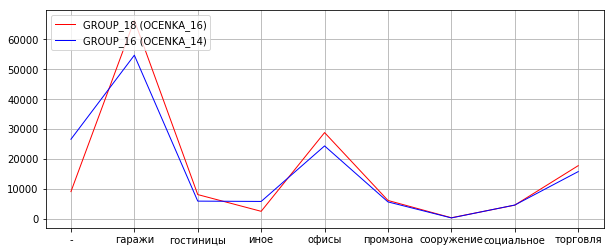

In [28]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(pd.DataFrame(df['GROUP_18'].value_counts()).sort_index(), color='r', alpha=1, linewidth=1, label='GROUP_18 (OCENKA_16)')
ax.plot(pd.DataFrame(df['GROUP_16'].value_counts()).sort_index(), color='b', alpha=1, linewidth=1, label='GROUP_16 (OCENKA_14)')
#ax.bar(pd.DataFrame(df['GROUP_18'].value_counts()).sort_index(), color='r', alpha=1, linewidth=1, label='GROUP_18', height=10)
ax.grid()
ax.legend(loc='upper left');

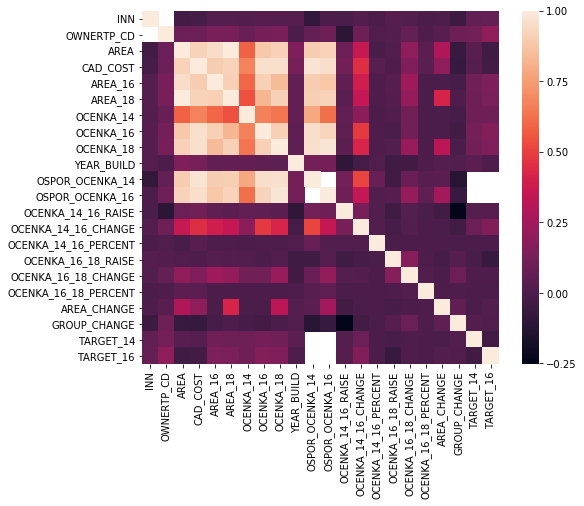

In [29]:
fig, ax = plt.subplots(figsize=(8,6.5))
df_corr = df.corr()
seaborn.heatmap(df_corr)

In [465]:
#Merge perechen lists: 2016, 2017, 2018
df_am_f16['AM_16'] = 1
df = df.merge(df_am_f16, on='CADNUM', how='outer')
df['AM_16'] = df['AM_16'].fillna(0)
df['AM_16'] = df['AM_16'].astype(int)
#df_am_f17['AM_17'] = 1
#df = df.merge(df_am_f17, on='CADNUM', how='outer')
#df['AM_17'] = df['AM_17'].fillna(0)
#df['AM_17'] = df['AM_17'].astype(int)
df_am_f18['AM_18'] = 1
df = df.merge(df_am_f18, on='CADNUM', how='outer')
df['AM_18'] = df['AM_18'].fillna(0)
df['AM_18'] = df['AM_18'].astype(int)
#df_am_f18a = pd.DataFrame({'CADNUM': ['1111', '2222'], 'AM_18a': [1, 1]})
#df = df.merge(df_am_f18a, on='CADNUM', how='outer')
len( df[(df['AM_16'].isna())] )
len( df[(df['AM_18'].isna())] )
df_ospor = df.copy()

26056

0

In [307]:
#WRITE!
df_ospor.to_csv('df_ospor.csv', sep='\t', index=False)

In [4]:
#READ
df_ospor = pd.read_csv('df_ospor.csv', sep='\t')
df_ospor.shape

/root/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8,9,10,14,16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(443080, 32)

df[['CADNUM','INN','CADCOST_15','COST_AFTER_OSPOR_16','AM_16','CADCOST_17','COST_AFTER_OSPOR_18','AM_18','CADCOST_19',
          'CADCOST_15_17_RAISE','CADCOST_15_17_CHANGE','CADCOST_15_17_PERCENT',
          'CADCOST_17_19_RAISE','CADCOST_17_19_CHANGE','CADCOST_17_19_PERCENT',
          'AREA_CHANGE','TARGET']][df['TARGET']==1]#TEST

fig, ax = plt.subplots(figsize=(15,5))
ax.hist(df['OCENKA_14_16_PERCENT'][(df['TARGET_14']==1)], color='r', alpha=0.5, linewidth=1, label='ospor count via % of cost change from 2014 to 2016', bins=100)
ax.hist(df['OCENKA_16_18_PERCENT'][(df['TARGET_16']==1)], color='b', alpha=0.5, linewidth=1, label='ospor count via % of cost change from 2016 to 2018', bins=100)
ax.grid()
ax.xaxis.set_label_text('percent of cadastre cost raise')
ax.yaxis.set_label_text('count of contestates')
ax.legend(loc='upper left');

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['GROUP_16'][(df['TARGET_14']==1)], color='b', alpha=0.5, linewidth=1, label='ospor count via % of cost change from 2016 to 2018')
ax.plot(df['GROUP_18'][(df['TARGET_16']==1)], color='b', alpha=0.5, linewidth=1, label='ospor count via % of cost change from 2016 to 2018')
#ax.hist(y_pred, color='b', alpha=0.5, linewidth=1, label='ospor count via % of cost change from 2016 to 2018', bins=100)
ax.grid()
ax.xaxis.set_label_text('percent of cadastre cost raise')
ax.yaxis.set_label_text('count of contestates')
ax.legend(loc='upper left');

## MERGE EXTERNAL DATA (CIAN, 2GIS)

In [ ]:
#PREPARE DF < MERGE
df = df_ospor.copy()
df = df[['CADNUM', 'TYPE', 'AREA', 'AREA_16', 'AREA_18', 'GROUP_16', 'GROUP_18', 'OCENKA_14', 'OCENKA_16', 'OCENKA_18', 'YEAR_BUILD', 'AO2',
         'OSPOR_OCENKA_14', 'OSPOR_OCENKA_16', 'OCENKA_14_16_RAISE', 'OCENKA_14_16_CHANGE', 'OCENKA_14_16_PERCENT', 'OCENKA_16_18_RAISE',
         'OCENKA_16_18_CHANGE', 'OCENKA_16_18_PERCENT', 'AREA_CHANGE', 'TARGET_14', 'TARGET_16', 'AM_16', 'AM_18']]
print('Rows count:', len(df))
df = df.loc[df.iloc[:,2:-2].dropna(how='all').index]
print('Rows count after drop most NA:', len(df))

#LOAD CIAN SALE
df_sale = pd.read_csv('//home/cian_sale_cost.csv', sep='\t')
display_side_by_side(df_sale.head(2), df_sale.tail(2))

#MERGE BY CADNUM
df = df.merge(df_sale, how='left', on='CADNUM')

#SPLIT ON CADNUM AND CAD
df_cadnum = df[df['SALE_COUNT'].notna()]
print('Len df_cadnum:', len(df_cadnum))
df_cad = df[df['SALE_COUNT'].isna()]
print('Len df_cad:', len(df_cad))

#GROUP BY CAD
df_sale['CAD'] = df_sale['CADNUM'].apply(lambda t: t[:13])
df_sale = df_sale.drop(columns=['CADNUM'])
df_sale = pd.concat([df_sale.groupby(['CAD'])['SALE_COUNT'].count(), 
                     df_sale.groupby(['CAD'])['SALE_MEAN'].mean(),
                     df_sale.groupby(['CAD'])['SALE_MEDIAN'].median(),
                     df_sale.groupby(['CAD'])['SALE_STD'].std()], axis=1)

df_sale.columns = ['SALE_COUNT','SALE_MEAN','SALE_MEDIAN','SALE_STD']
df_sale['SALE_STD'] = df_sale['SALE_STD'].fillna(0)
df_sale = df_sale.reset_index()
display_side_by_side(df_sale.head(2), df_sale.tail(2)) #, df_merg[len(df_merg)//2:10+len(df_merg)//2]

#OSPOR MERGE SALE BY CAD
df_cad = df_cad.iloc[:,:-4]
df_cad['CAD'] = df_cad['CADNUM'].apply(lambda t: t[:13])
df_cad = df_cad.merge(df_sale, on='CAD', how='left')#.drop_duplicates('CADNUM')
df_cad = df_cad.drop(columns=['CAD'])

print('Len df_cad after merged df_sale by CAD:', len(df_cad))

df = pd.concat([df_cadnum, df_cad], sort=False).reset_index(drop=True)
df = df.loc[df.iloc[:,-4:].dropna(how='all').index]
display_side_by_side(df.tail(2))

In [ ]:
#LOAD CIAN RENT
df_rent = pd.read_csv('//home/cian_rent_cost.csv', sep='\t')
display_side_by_side(df_rent.head(2), df_rent.tail(2))

#MERGE BY CADNUM
df = df.merge(df_rent, how='left', on='CADNUM')

#SPLIT ON CADNUM AND CAD
df_cadnum = df[df['RENT_COUNT'].notna()]
print('Len df_cadnum:', len(df_cadnum))
df_cad = df[df['RENT_COUNT'].isna()]
print('Len df_cad:', len(df_cad))

#GROUP BY CAD
df_rent['CAD'] = df_rent['CADNUM'].apply(lambda t: t[:13])
df_rent = df_rent.drop(columns=['CADNUM'])
df_rent = pd.concat([df_rent.groupby(['CAD'])['RENT_COUNT'].count(), 
                     df_rent.groupby(['CAD'])['RENT_MEAN'].mean(),
                     df_rent.groupby(['CAD'])['RENT_MEDIAN'].median(),
                     df_rent.groupby(['CAD'])['RENT_STD'].std()], axis=1)

df_rent.columns = ['RENT_COUNT','RENT_MEAN','RENT_MEDIAN','RENT_STD']
df_rent['RENT_STD'] = df_rent['RENT_STD'].fillna(0)
df_rent = df_rent.reset_index()
display_side_by_side(df_rent.head(2), df_rent.tail(2)) #, df_merg[len(df_merg)//2:10+len(df_merg)//2]

#OSPOR MERGE RENT BY CAD
df_cad = df_cad.iloc[:,:-4]
df_cad['CAD'] = df_cad['CADNUM'].apply(lambda t: t[:13])
df_cad = df_cad.merge(df_rent, on='CAD', how='left')#.drop_duplicates('CADNUM')
df_cad = df_cad.drop(columns=['CAD'])

print('Len df_cad after merged df_rent by CAD:', len(df_cad))

df = pd.concat([df_cadnum, df_cad], sort=False)
df = df.loc[df.iloc[:,-4:].dropna(how='all').index]
display_side_by_side(df.tail(2))

In [ ]:
#LOAD 2GIS PURPOSE
df_2gis = pd.read_csv('//home/2gis_purpose.csv', sep='\t')
df = df.merge(df_2gis, on='CADNUM', how='left')#.drop_duplicates('CADNUM')
df['PURPOSE'] = df['PURPOSE'].fillna('неизвестно')
df['SALE_COUNT'] = df['SALE_COUNT'].fillna(0).astype(int)
df['RENT_COUNT'] = df['RENT_COUNT'].fillna(0).astype(int)
df['ORG_COUNT'] = df['ORG_COUNT'].fillna(0).astype(int)

display_side_by_side(df.head(2), df.tail(2))
df_market_cost = df.copy()

In [ ]:
#df_market_cost['AREA_16'] = df_market_cost.apply(lambda x: x['AREA_18'] if (x['AREA_16'] == 0) & (x['AREA_18']!=0) else x['AREA_16'], axis=1)
#df_market_cost['AREA_18'] = df_market_cost.apply(lambda x: x['AREA_16'] if (x['AREA_18'] == 0) & (x['AREA_16']!=0) else x['AREA_18'], axis=1)
#Get area from pred-year or post-year
df_market_cost['AREA_16'] = df_market_cost.apply(lambda x: x['AREA'] if (x['AREA_16'] == 0) & (x['AREA']!=0) else x['AREA_16'], axis=1)
df_market_cost['AREA_18'] = df_market_cost.apply(lambda x: x['AREA'] if (x['AREA_18'] == 0) & (x['AREA']!=0) else x['AREA_18'], axis=1)
#calc object market_cost by area
df_market_cost['MARKET_COST'] = df_market_cost.apply(lambda x: x['SALE_MEAN']*x['AREA_18'] if x['SALE_MEAN']*x['AREA_18']<x['OCENKA_18'] else x['OCENKA_18'], axis=1)
df_market_cost['MARKET_COST'] = df_market_cost.apply(lambda x: x['SALE_MEAN'] if x['SALE_MEAN']!=0 else x['OCENKA_16'], axis=1)
display_side_by_side(df_market_cost.head(), df_market_cost.tail())

In [14]:
#WRITE!
df_market_cost.to_csv('//home/df_market_cost.csv', sep='\t', index=False)

In [4]:
#READ!
df_market_cost = pd.read_csv('//home/df_market_cost.csv', sep='\t')

In [5]:
print(len(df_market_cost))
df_market_cost = df_market_cost.drop(df_market_cost[pd.isna(df_market_cost['OCENKA_14'])&pd.isna(df_market_cost['OCENKA_16'])&pd.isna(df_market_cost['OCENKA_18'])].index)
print(len(df_market_cost))

132875
132875


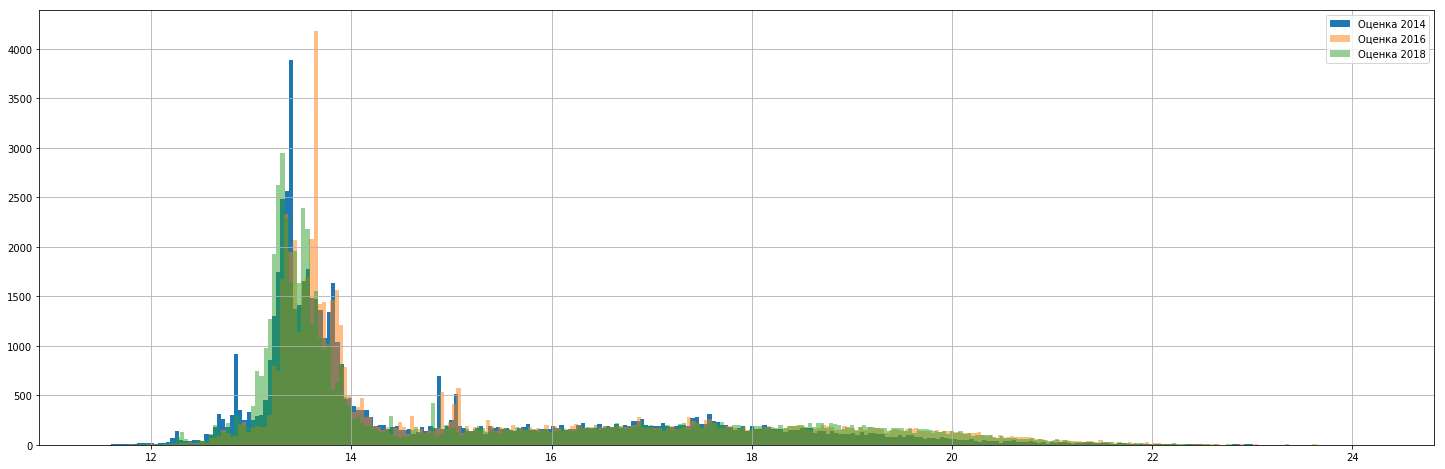

In [6]:
#SHOW OCENKA COUNT FOR CONTROL YEARS
fig, ax = plt.subplots(figsize=(25,8))
df = df_market_cost[(df_market_cost['OCENKA_14']>0)&(df_market_cost['OCENKA_16']>0)&(df_market_cost['OCENKA_18']>0)]
plt.hist(np.log(df['OCENKA_14'][df['OCENKA_14']>100000]), bins=300, alpha=  1, label='Оценка 2014')
plt.hist(np.log(df['OCENKA_16'][df['OCENKA_16']>100000]), bins=300, alpha=0.5, label='Оценка 2016')
plt.hist(np.log(df['OCENKA_18'][df['OCENKA_18']>100000]), bins=300, alpha=0.5, label='Оценка 2018')
ax.grid()
ax.legend(loc='upper right');

## TRAIN CATBOOST MODEL 1 (who contestate?)

#Calc coefs for compensation inflation and zero 'OCENKA' values

df = df_market_cost[df_market_cost['AM_16']==1][['CADNUM','PURPOSE','TYPE','AO2','GROUP_16','AREA_16','OCENKA_14','OCENKA_16','OCENKA_14_16_CHANGE',
                                    'SALE_COUNT','SALE_MEAN','SALE_MEDIAN','SALE_STD','RENT_COUNT','RENT_MEAN','RENT_MEDIAN','RENT_STD','ORG_COUNT',
                                    'AO2','AO2','AO2','AO2','AO2','AO2','OSPOR_OCENKA_14','OSPOR_OCENKA_16']] #Filtered by tax list
df.columns = ['CADNUM','PURPOSE','TYPE','AO2','GROUP','AREA','OCENKA1','OCENKA2','OCENKA_CHANGE',
              'MARKET_COST','SALE_MEAN','SALE_MEDIAN','SALE_STD','RENT_COUNT','MARKET_RENT','RENT_MEDIAN','RENT_STD','ORG_COUNT',
              'F00','F01','F02','F03','F04','F05','OSPOR_IN_PAST','TARGET']

df_ocenka_coef = df[(df['OCENKA1']>0)&(df['OCENKA2']>0)]
print(df_ocenka_coef.shape, df_ocenka_coef[df_ocenka_coef['OCENKA2']==0].shape)
ocenka_coef_14_16 = (df_ocenka_coef['OCENKA2']/df_ocenka_coef['OCENKA1']).median()

df = df_market_cost[df_market_cost['AM_18']==1][['CADNUM','PURPOSE','TYPE','AO2','GROUP_18','AREA_18','OCENKA_16','OCENKA_18','OCENKA_16_18_CHANGE',
                                                 'SALE_COUNT','SALE_MEAN','SALE_MEDIAN','SALE_STD','RENT_COUNT','RENT_MEAN','RENT_MEDIAN','RENT_STD','ORG_COUNT',
                                                 'AO2','AO2','AO2','AO2','AO2','AO2','OSPOR_OCENKA_16','OSPOR_OCENKA_16']] #Filtered by tax list
df.columns = ['CADNUM','PURPOSE','TYPE','AO2','GROUP','AREA','OCENKA1','OCENKA2','OCENKA_CHANGE',
              'MARKET_COST','SALE_MEAN','SALE_MEDIAN','SALE_STD','RENT_COUNT','MARKET_RENT','RENT_MEDIAN','RENT_STD','ORG_COUNT',
              'F00','F01','F02','F03','F04','F05','OSPOR_IN_PAST','TARGET']

df_ocenka_coef = df[(df['OCENKA1']>0)&(df['OCENKA2']>0)]
print(df_ocenka_coef.shape, df_ocenka_coef[df_ocenka_coef['OCENKA2']==0].shape)
ocenka_coef_16_18 = (df_ocenka_coef['OCENKA2']/df_ocenka_coef['OCENKA1']).median()

print('ocenka_coef_14_16\t', ocenka_coef_14_16)
print('ocenka_coef_16_18\t', ocenka_coef_16_18)

In [7]:
#Work with binary classification, 0 - big class (no contestate), 1 - small class (contestate)

print('Preparing data for CatBoost model TRAINING')
df = df_market_cost[df_market_cost['AM_16']==1][['CADNUM','PURPOSE','TYPE','AO2','GROUP_16','AREA_16','OCENKA_14','OCENKA_16','OCENKA_14_16_CHANGE',
                                    'SALE_COUNT','SALE_MEAN','SALE_MEDIAN','SALE_STD','RENT_COUNT','RENT_MEAN','RENT_MEDIAN','RENT_STD','ORG_COUNT',
                                    'AO2','AO2','AO2','AO2','AO2','AO2','OSPOR_OCENKA_14','OSPOR_OCENKA_16']] #Filtered by tax list
df.columns = ['CADNUM','PURPOSE','TYPE','AO2','GROUP','AREA','OCENKA1','OCENKA2','OCENKA_CHANGE',
              'SALE_COUNT','MARKET_COST','SALE_MEDIAN','SALE_STD','RENT_COUNT','MARKET_RENT','RENT_MEDIAN','RENT_STD','ORG_COUNT',
              'F00','F01','F02','F03','F04','F05','OSPOR_IN_PAST','TARGET']
#df = df.drop(columns=['SALE_COUNT','SALE_STD','RENT_COUNT','RENT_STD','ORG_COUNT'])
print('In perechen 2016 rows count:',len(df), 'Rows TARGET>0:', len(df[df['TARGET']>0]))

#df_ocenka_coef = df[(df['OCENKA1']>0)&(df['OCENKA2']>0)]
#print(df_ocenka_coef.shape)
#ocenka_coef = (df_ocenka_coef['OCENKA2']/df_ocenka_coef['OCENKA1']).median()
#df['OCENKA1'] = df.apply(lambda row: row['OCENKA2']*1/ocenka_coef if row['OCENKA1']==0 else row['OCENKA1'], axis=1)

#df = df[df['OCENKA1']>0] #Filtered positive values
#df = df[df['OCENKA2']>0] #Filtered positive values
df['F00'] = df['MARKET_RENT']/df['OCENKA2'] #Feathure
df['F01'] = df['MARKET_COST']/df['OCENKA2'] #Feathure from Andrey's sister-DS
df['F02'] = df['MARKET_COST']-df['MARKET_COST'].mean() #Feathure mean
df['F03'] = df['OCENKA1']-df['OCENKA1'].mean() #Feathure mean
df['F04'] = df['OCENKA2']-df['OCENKA2'].mean() #Feathure mean
df['F05'] = df.apply(lambda row: 1 if (row['OCENKA2']-row['MARKET_COST'])>=0 else 0, axis=1).astype(int) #Feathure

#df['TARGET'] = df['TARGET'].fillna(0)
#df['TARGET'] = df['TARGET']/df['OCENKA2']
df['TARGET'] = df['TARGET'].fillna(0)
df = df[(df['OCENKA2']-df['TARGET'])>=0] #Filtered by contestated cost down
print('Rows filtered by contestated cost down', len(df), 'Rows TARGET>0:', len(df[df['TARGET']>0]))

df['OSPOR_IN_PAST'] = df['OSPOR_IN_PAST'].fillna(0).apply(lambda x: 1 if x!=0 else 0)
df['TARGET'] = df['TARGET'].fillna(0).apply(lambda x: 1 if x>0 else 0) #Set TARGET (0/1)

#df = df[['CADNUM','AO2','GROUP','AREA','OCENKA1','OCENKA2','OCENKA_CHANGE','MARKET_COST','F01','F02','F03','F04','OSPOR_IN_PAST','TARGET']]
df = df.fillna(0)

print('Drop zero area rows count:',len(df[df['AREA']==0].index), 'Rows TARGET>0:', len(df[df['TARGET']>0]))
df = df.drop(df[df['AREA']==0].index)
print('Rows without zero area:',len(df), 'Rows TARGET>0:', len(df[df['TARGET']>0]))
df = df.drop_duplicates()
print('Rows after drop duplicates:', len(df), 'Rows TARGET>0:', len(df[df['TARGET']>0]))
df = df.dropna()
print('Rows after drop NA:', len(df), 'Cols:', df.shape, 'Rows TARGET>0:', len(df[df['TARGET']>0]))

#df = pd.get_dummies(df, columns=['AO2', 'TYPE', 'GROUP'])
#print('Cols after get_dummies:', df.shape)

#norm_features = [4,5,6,7,8,10,11,12]
#scaler = Normalizer().fit(df.iloc[:,norm_features])
#df.iloc[:,norm_features] = scaler.transform(df.iloc[:,norm_features])

df_training = df.copy()

#   TRAINING DATASET 
#-----------------------------------------------------------------------------------------------------------------
# PREDICTING DATASET

print('\nPreparing data for CatBoost model PREDICTING')
df = df_market_cost[df_market_cost['AM_18']==1][['CADNUM','PURPOSE','TYPE','AO2','GROUP_18','AREA_18','OCENKA_16','OCENKA_18','OCENKA_16_18_CHANGE',
                                                 'SALE_COUNT','SALE_MEAN','SALE_MEDIAN','SALE_STD','RENT_COUNT','RENT_MEAN','RENT_MEDIAN','RENT_STD','ORG_COUNT',
                                                 'AO2','AO2','AO2','AO2','AO2','AO2','OSPOR_OCENKA_16','OSPOR_OCENKA_16']] #Filtered by tax list
df.columns = ['CADNUM','PURPOSE','TYPE','AO2','GROUP','AREA','OCENKA1','OCENKA2','OCENKA_CHANGE',
              'SALE_COUNT','MARKET_COST','SALE_MEDIAN','SALE_STD','RENT_COUNT','MARKET_RENT','RENT_MEDIAN','RENT_STD','ORG_COUNT',
              'F00','F01','F02','F03','F04','F05','OSPOR_IN_PAST','TARGET']
#df = df.drop(columns=['SALE_COUNT','SALE_STD','RENT_COUNT','RENT_STD','ORG_COUNT'])
print('In perechen 2018 rows count:',len(df), 'Rows TARGET>0:', len(df[df['TARGET']>0]))

#df_ocenka_coef = df[(df['OCENKA1']>0)&(df['OCENKA2']>0)]
#print(df_ocenka_coef.shape)
#ocenka_coef = (df_ocenka_coef['OCENKA2']/df_ocenka_coef['OCENKA1']).median()
#df['OCENKA1'] = df.apply(lambda row: row['OCENKA2']*1/ocenka_coef if row['OCENKA1']==0 else row['OCENKA1'], axis=1)

#df = df[df['OCENKA1']>0] #Filtered positive values
#df = df[df['OCENKA2']>0] #Filtered positive values
df['F00'] = df['MARKET_RENT']/df['OCENKA2'] #Feathure
df['F01'] = df['MARKET_COST']/df['OCENKA2'] #Feathure from Andrey's sister-DS
df['F02'] = df['MARKET_COST']-df['MARKET_COST'].mean() #Feathure mean
df['F03'] = df['OCENKA1']-df['OCENKA1'].mean() #Feathure mean
df['F04'] = df['OCENKA2']-df['OCENKA2'].mean() #Feathure mean
df['F05'] = df.apply(lambda row: 1 if (row['OCENKA2']-row['MARKET_COST'])>=0 else 0, axis=1).astype(int) #Feathure

#df['TARGET'] = df['TARGET'].fillna(0)
#df['TARGET'] = df['TARGET']/df['OCENKA2']
df['TARGET'] = df['TARGET'].fillna(0)
df = df[(df['OCENKA2']-df['TARGET'])>=0] #Filtered by contestated cost down
print('Rows filtered by contestated cost down', len(df), 'Rows TARGET>0:', len(df[df['TARGET']>0]))

df['OSPOR_IN_PAST'] = df['OSPOR_IN_PAST'].fillna(0).apply(lambda x: 1 if x!=0 else 0)
df['TARGET'] = df['TARGET'].fillna(0).apply(lambda x: 1 if x>0 else 0) #Set TARGET (0/1)

#df = df[['CADNUM','AO2','GROUP','AREA','OCENKA1','OCENKA2','OCENKA_CHANGE','MARKET_COST','F01','F02','F03','F04','OSPOR_IN_PAST','TARGET']]
df = df.fillna(0)

print('Drop zero area rows count:',len(df[df['AREA']==0].index), 'Rows TARGET>0:', len(df[df['TARGET']>0]))
df = df.drop(df[df['AREA']==0].index)
print('Rows without zero area:',len(df), 'Rows TARGET>0:', len(df[df['TARGET']>0]))
df = df.drop_duplicates()
print('Rows after drop duplicates:', len(df), 'Rows TARGET>0:', len(df[df['TARGET']>0]))
df = df.dropna()
print('Rows after drop NA:', len(df), 'Cols:', df.shape, 'Rows TARGET>0:', len(df[df['TARGET']>0]))

#df = pd.get_dummies(df, columns=['AO2', 'TYPE', 'GROUP'])
#print('Cols after get_dummies:', df.shape)

#norm_features = [4,5,6,7,8,10,11,12] get from train
#scaler = Normalizer().fit(df.iloc[:,norm_features])
#df.iloc[:,norm_features] = scaler.transform(df.iloc[:,norm_features])

# Drop pred set columns not in train set
#for col in df.columns:
#    if col not in df_training.columns:
#        print('Dropped:', col)
#        df = df.drop(columns=col)

df_predicting = df.copy()

#----------------------------------------------------------------------------------------

# Categorial columns set
cat_features = [0,1,2,3] #Categorial columns

# Balancing binary classess
scale_pos_weight = len(df_training[df_training['TARGET']==0])/len(df_training[df_training['TARGET']==1])*1.
print('\nClass 1 (0,1) weight multiplier', scale_pos_weight)

Preparing data for CatBoost model TRAINING
In perechen 2016 rows count: 95368 Rows TARGET>0: 8232
Rows filtered by contestated cost down 94860 Rows TARGET>0: 7724
Drop zero area rows count: 12694 Rows TARGET>0: 7724
Rows without zero area: 82166 Rows TARGET>0: 7724
Rows after drop duplicates: 79922 Rows TARGET>0: 7109
Rows after drop NA: 79922 Cols: (79922, 26) Rows TARGET>0: 7109

Preparing data for CatBoost model PREDICTING
In perechen 2018 rows count: 111337 Rows TARGET>0: 9632
Rows filtered by contestated cost down 110170 Rows TARGET>0: 8465
Drop zero area rows count: 110 Rows TARGET>0: 8465
Rows without zero area: 110060 Rows TARGET>0: 8465
Rows after drop duplicates: 106213 Rows TARGET>0: 7622
Rows after drop NA: 106213 Cols: (106213, 26) Rows TARGET>0: 7622

Class 1 (0,1) weight multiplier 10.242368828245885


#DATASET SMALL CLASS MULTIPLY
X0 = df_ospor_mod[df_ospor_mod['TARGET']==0]
X1 = df_ospor_mod[df_ospor_mod['TARGET']==1]
X = pd.concat([X0, X1,X1,X1,X1,X1, X1,X1,X1,X1,X1,X1])
X = X.sample(frac=1).reset_index(drop=True)
y = X['TARGET']
len(X[X['TARGET']==1])
X = X.iloc[:,1:].drop(columns='TARGET')

%%time
param_grid = {'learning_rate': [0.7, 0.9],
              'depth': [12,13],
              'l2_leaf_reg': [9, 15]}
estimator = CatBoostClassifier(iterations=50, eval_metric='F1', leaf_estimation_method='Gradient', 
                               scale_pos_weight=scale_pos_weight, cat_features=cat_features, logging_level='Silent')
optimizer = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)
optimizer.fit(X, y)
print(optimizer.best_score_, optimizer.best_params_)
#0.8888800180964166 {'depth': 12, 'l2_leaf_reg': 15, 'learning_rate': 0.9}
#CPU times: user 6min 29s, sys: 23.3 s, total: 6min 52s
#Wall time: 9min 50s

In [8]:
%%time
ansible = 15 #prefer odd number!

preds = []

y = df_training['TARGET'].copy()
X = df_training.iloc[:,1:].drop(columns='TARGET').copy()
F = df_predicting.iloc[:,1:].drop(columns='TARGET').copy()

#X, y, F = dumm(df_training, df_target, df_predicting)
#X, y, F = norm(X, y, F)
#Split your data into train and validation
#When you will be training your model, you will have to detect overfitting and select best parameters. To do that you need to have a validation dataset.
from sklearn.model_selection import train_test_split

#Train CatBoost model
from catboost import CatBoostClassifier
#from catboost import CatBoostRegressor

for i in range(ansible):
    
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.632, random_state=i) #train_size=0.632

    model = CatBoostClassifier(
        iterations=50,
        random_seed=i,
        depth=12,
        l2_leaf_reg=15,
        learning_rate=0.9,
        eval_metric='Precision', #Logloss,CrossEntropy,Precision,Recall,F1,BalancedAccuracy,BalancedErrorRate,MCC,Accuracy,ZeroOneLoss,CtrFactor,AUC,BrierScore       #eval_metric - VERY SENSITIVE TO PREDICT CLASS SUMM !!!!!
        leaf_estimation_method='Gradient',
        scale_pos_weight=scale_pos_weight,
        cat_features=cat_features
    )
    model.fit(
        X_train, y_train,
        eval_set=(X_validation, y_validation),
        logging_level='Silent',
        plot=False
    )
    #print('Model is fitted: '+str(model.is_fitted()))
    print('Model params:\n',model.get_params())
    
    #Feathure importance
    importances = model.get_feature_importance(prettified=True)
    for i in importances:
        print(round(i[1],3), '/', str(i[0].decode('utf-8')), end='\t')
    
    y_pred_X = model.predict(X_validation)
    print('\n         Predicted on X dataset: ', model.predict(X).sum(), '\tfrom real', sum(y))
    print('     Predicted on X_train dataset: ', model.predict(X_train).sum(), '\tfrom real', sum(y_train))
    print('Predicted on X_validation dataset: ', model.predict(X_validation).sum(), '\tfrom real', sum(y_validation))
    y_pred = model.predict(F)
    print('           Predicted on F dataset: ', sum(y_pred))
    preds.append(y_pred)

    print('precision:', precision_score(y_validation ,y_pred_X), '\trecall:', recall_score(y_validation ,y_pred_X), '\tF1:', f1_score(y_validation ,y_pred_X), '\taccuracy:', model.score(X_validation, y_validation))

/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Model params:
 {'cat_features': [0, 1, 2, 3], 'scale_pos_weight': 10.242368828245885, 'eval_metric': 'Precision', 'random_seed': 0, 'leaf_estimation_method': 'Gradient', 'loss_function': 'Logloss', 'l2_leaf_reg': 15, 'depth': 12, 'learning_rate': 0.9, 'iterations': 50}
16.624 / GROUP	8.551 / OCENKA2	8.394 / RENT_STD	7.757 / RENT_COUNT	6.372 / SALE_STD	6.072 / OCENKA1	5.706 / RENT_MEDIAN	5.625 / SALE_COUNT	5.193 / AO2	4.254 / F01	4.191 / AREA	3.882 / MARKET_COST	3.585 / F00	3.363 / MARKET_RENT	3.259 / SALE_MEDIAN	3.253 / OCENKA_CHANGE	3.187 / OSPOR_IN_PAST	0.467 / PURPOSE	0.114 / F04	0.09 / TYPE	0.06 / ORG_COUNT	0.0 / 19	0.0 / 20	0.0 / 22	
         Predicted on X dataset:  11367.0 	from real 7109
     Predicted on X_train dataset:  7189.0 	from real 4611
Predicted on X_validation dataset:  4178.0 	from real 2498
           Predicted on F dataset:  7625.0
precision: 0.4784585926280517 	recall: 0.800240192153723 	F1: 0.5988615937687238 	accuracy: 0.9089487284101727
Model params:
 {'cat_fe

In [9]:
for_powerpoint = []
for i in importances:
    for_powerpoint.append([str(i[0].decode('utf-8')), i[1]])
display_side_by_side(pd.DataFrame(for_powerpoint, columns=['NAME','PR']).set_index('NAME',drop=True))

,PR
NAME,
GROUP,17.38
RENT_COUNT,8.36
SALE_STD,7.72
RENT_STD,7.47
SALE_COUNT,6.27
F01,5.97
OCENKA1,5.85
F00,5.70
OCENKA2,5.25


In [10]:
#TEST PRECISION METRIC
df = pd.DataFrame({'y':y_validation, 'y_pred':y_pred_X })
TP = len(df[(df['y']==1) & (df['y_pred']==1)])
FP = len(df[(df['y']==0) & (df['y_pred']==1)])
TP/(TP + FP)
#0.5660899653979239

0.4891041162227603

In [11]:
#Mean of CatBoostClassifier ansible
#np.set_printoptions(threshold=np.nan, linewidth=150)
y_pred = np.round(np.round(np.array(preds).T.sum(axis=1)).astype(int)/ansible)
df_predicting['TARGET'] = y_pred
print( np.round(np.array(preds).sum(axis=1).mean()).astype(int), 'mean predicted from', len(y_pred), 'rielty objects' )
print( len(df_predicting[df_predicting['TARGET']==1]), 'ansible', ansible, 'contestations predicted from', len(y_pred), 'rielty objects' )
df_pred_class = df_predicting[['CADNUM','TARGET']] #Predicted classification (who go to contestate for second predict)
df_pred_class = df_pred_class[df_pred_class['TARGET']==1]
df_pred_class.columns = ['CADNUM','TARGET_MOD_1']
#4697

6977 mean predicted from 106213 rielty objects
4636 ansible 15 contestations predicted from 106213 rielty objects


In [41]:
np.set_printoptions(threshold=np.nan, linewidth=150)
np.array(preds).T.astype(int).sum(axis=1)[:100]

array([0.4       , 0.66666667, 0.        , 0.26666667, 0.46666667, 0.        , 0.33333333, 0.        , 0.46666667, 0.        , 0.06666667,
       0.4       , 0.        , 0.6       , 0.        , 0.93333333, 0.66666667, 0.        , 0.06666667, 0.        , 0.06666667, 0.        ,
       0.73333333, 0.        , 0.66666667, 1.        , 0.86666667, 0.        , 0.6       , 0.        , 1.        , 0.26666667, 0.        ,
       0.        , 0.06666667, 0.        , 0.        , 0.        , 0.6       , 0.        , 0.        , 0.06666667, 0.        , 0.06666667,
       0.26666667, 0.06666667, 0.93333333, 0.4       , 0.        , 0.53333333, 0.46666667, 0.        , 0.46666667, 0.        , 0.        ,
       0.46666667, 0.46666667, 0.66666667, 0.        , 0.53333333, 0.        , 0.33333333, 0.6       , 0.        , 0.        , 0.8       ,
       0.        , 0.06666667, 0.        , 0.73333333, 0.        , 0.        , 0.        , 0.        , 0.        , 0.73333333, 0.66666667,
       0.13333333, 1.      

In [24]:
print( sum(np.round(np.array(preds).T.sum(axis=1)).astype(int)/15), 'ansible', ansible, 'contestations predicted from', len(y_pred), 'rielty objects' )

6977.333333332206 ansible 15 contestations predicted from 106213 rielty objects


In [24]:
#8640 contestations predicted from 246726 rielty objects
#TO-DO dover. int.

,В Перечне 2017-2018 гг
GROUP,
36860,гаражи
4709,гостиницы
16943,офисы
1920,промзона
2339,социальное
9421,торговля
,Оспаривали 2017-2018 гг
GROUP,
68,гаражи


CPU times: user 2.66 s, sys: 3.3 s, total: 5.96 s
Wall time: 416 ms


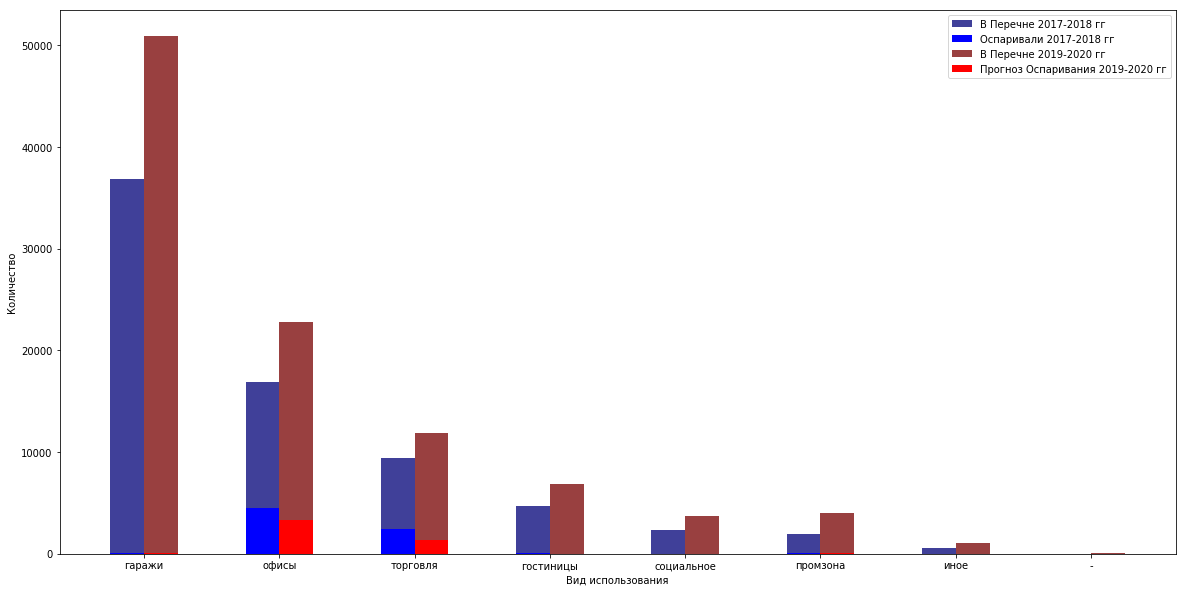

In [25]:
%%time
df1 = df_training.copy()
df2 = df_predicting.copy()
display_side_by_side(pd.DataFrame(df1['GROUP'][(df1['TARGET']==0)&(df1['GROUP']!='-')&(df1['GROUP']!='иное')].value_counts().sort_index().index, df1['GROUP'][(df1['TARGET']==0)&(df1['GROUP']!='-')&(df1['GROUP']!='иное')].value_counts().sort_index(), columns=['В Перечне 2017-2018 гг']),
                     pd.DataFrame(df1['GROUP'][(df1['TARGET']==1)&(df1['GROUP']!='-')&(df1['GROUP']!='иное')].value_counts().sort_index().index, df1['GROUP'][(df1['TARGET']==1)&(df1['GROUP']!='-')&(df1['GROUP']!='иное')].value_counts().sort_index(), columns=['Оспаривали 2017-2018 гг']),
                     pd.DataFrame(df2['GROUP'][(df2['TARGET']==0)&(df2['GROUP']!='-')&(df2['GROUP']!='иное')].value_counts().sort_index().index, df2['GROUP'][(df2['TARGET']==0)&(df2['GROUP']!='-')&(df2['GROUP']!='иное')].value_counts().sort_index(), columns=['В Перечне 2019-2020 гг']),
                     pd.DataFrame(df2['GROUP'][(df2['TARGET']==1)&(df2['GROUP']!='-')&(df2['GROUP']!='иное')].value_counts().sort_index().index, df2['GROUP'][(df2['TARGET']==1)&(df2['GROUP']!='-')&(df2['GROUP']!='иное')].value_counts().sort_index(), columns=['Прогноз Оспаривания 2019-2020 гг']))

fig, ax = plt.subplots(figsize=(20,10))
#ax.plot(df_ospor['GROUP_16'][(df_ospor['TARGET_14']==1)], color='b', alpha=0.5, linewidth=1, label='ospor count via % of cost change from 2016 to 2018')
df = df_training.copy()
ax.bar(df1['GROUP'][df1['TARGET']==0].value_counts().index, df1['GROUP'][df1['TARGET']==0].value_counts(), -.25, align='edge', color='#404099', label='В Перечне 2017-2018 гг')#'Model train 17-18')
ax.bar(df1['GROUP'][df1['TARGET']==1].value_counts().index, df1['GROUP'][df1['TARGET']==1].value_counts(), -.25, align='edge', color='#0000ff', label='Оспаривали 2017-2018 гг')#'Model train 17-18 contestations')
df = df_predicting.copy()
ax.bar(df2['GROUP'][df2['TARGET']==0].value_counts().index, df2['GROUP'][df2['TARGET']==0].value_counts(), .25, align='edge', color='#994040', label='В Перечне 2019-2020 гг')#'Model predict 19-20')
ax.bar(df2['GROUP'][df2['TARGET']==1].value_counts().index, df2['GROUP'][df2['TARGET']==1].value_counts(), .25, align='edge', color='#ff0000', label='Прогноз Оспаривания 2019-2020 гг')#'Model predict 19-20 contestations')
ax.set_xlabel('Вид использования')
ax.set_ylabel('Количество')
ax.legend()

## TRAIN CATBOOST MODEL 2 OVER MODEL 1 (how much contestate?)

In [36]:
#Work with regression, TARGET - new contestated cost of realty object - (not allowed negative values)

print('Preparing data for CatBoost model TRAINING')
df = df_market_cost[df_market_cost['AM_16']==1][['CADNUM','PURPOSE','TYPE','AO2','GROUP_16','AREA_16','OCENKA_14','OCENKA_16','OCENKA_14_16_CHANGE',
                                    'SALE_COUNT','SALE_MEAN','SALE_MEDIAN','SALE_STD','RENT_COUNT','RENT_MEAN','RENT_MEDIAN','RENT_STD','ORG_COUNT',
                                    'AO2','AO2','AO2','AO2','AO2','AO2','OSPOR_OCENKA_14','OSPOR_OCENKA_16']] #Filtered by tax list
df.columns = ['CADNUM','PURPOSE','TYPE','AO2','GROUP','AREA','OCENKA1','OCENKA2','OCENKA_CHANGE',
              'SALE_COUNT','MARKET_COST','SALE_MEDIAN','SALE_STD','RENT_COUNT','MARKET_RENT','RENT_MEDIAN','RENT_STD','ORG_COUNT',
              'F00','F01','F02','F03','F04','F05','OSPOR_IN_PAST','TARGET']
print('In perechen 2016 rows count:',len(df), 'Rows TARGET>0:', len(df[df['TARGET']>0]))

#df_ocenka_coef = df[(df['OCENKA1']>0)&(df['OCENKA2']>0)]
#print(df_ocenka_coef.shape)
#ocenka_coef = (df_ocenka_coef['OCENKA2']/df_ocenka_coef['OCENKA1']).median()
#df['OCENKA1'] = df.apply(lambda row: row['OCENKA2']*1/ocenka_coef if row['OCENKA1']==0 else row['OCENKA1'], axis=1)

#df = df[df['OCENKA1']>0] #Filtered positive values
#df = df[df['OCENKA2']>0] #Filtered positive values
df['F00'] = df['MARKET_RENT']/df['OCENKA2'] #Feathure
df['F00'] = df['MARKET_RENT']/df['OCENKA2'] #Feathure
df['F01'] = df['MARKET_COST']/df['OCENKA2'] #Feathure from Andrey's sister-DS
df['F02'] = df['MARKET_COST']-df['MARKET_COST'].mean() #Feathure mean
df['F03'] = df['OCENKA1']-df['OCENKA1'].mean() #Feathure mean
df['F04'] = df['OCENKA2']-df['OCENKA2'].mean() #Feathure mean
df['F05'] = df.apply(lambda row: 1 if (row['OCENKA2']-row['MARKET_COST'])>=0 else 0, axis=1).astype(int) #Feathure

#df['TARGET'] = df['TARGET'].fillna(0)
#df['TARGET'] = df['TARGET']/df['OCENKA2']
df['TARGET'] = df['TARGET'].fillna(0)
df = df[(df['OCENKA2']-df['TARGET'])>=0] #Filtered by contestated cost down
print('Rows filtered by contestated cost down', len(df), 'Rows TARGET>0:', len(df[df['TARGET']>0]))

df['OSPOR_IN_PAST'] = df['OSPOR_IN_PAST'].fillna(0).apply(lambda x: 1 if x!=0 else 0)
#df['TARGET'] = df['TARGET'].fillna(0).apply(lambda x: 1 if x>0 else 0) #Set TARGET (0/1)

#df = df[['CADNUM','AO2','GROUP','AREA','OCENKA1','OCENKA2','OCENKA_CHANGE','MARKET_COST','F01','F02','F03','F04','OSPOR_IN_PAST','TARGET']]
df = df.fillna(0)

print('Drop zero area rows count:',len(df[df['AREA']==0].index), 'Rows TARGET>0:', len(df[df['TARGET']>0]))
df = df.drop(df[df['AREA']==0].index)
print('Rows without zero area:',len(df), 'Rows TARGET>0:', len(df[df['TARGET']>0]))
df = df.drop_duplicates()
print('Rows after drop duplicates:', len(df), 'Rows TARGET>0:', len(df[df['TARGET']>0]))
df = df.dropna()
print('Rows after drop NA:', len(df), 'Cols:', df.shape, 'Rows TARGET>0:', len(df[df['TARGET']>0]))

#df = pd.get_dummies(df, columns=['AO2', 'TYPE', 'GROUP'])
#print('Cols after get_dummies:', df.shape)

#norm_features = [4,5,6,7,8,10,11,12]
#scaler = Normalizer().fit(df.iloc[:,norm_features])
#df.iloc[:,norm_features] = scaler.transform(df.iloc[:,norm_features])

df = df[df['TARGET']>0]
df_training = df.copy()

#   TRAINING DATASET 
#-----------------------------------------------------------------------------------------------------------------
# PREDICTING DATASET

print('\nPreparing data for CatBoost model PREDICTING')
df = df_market_cost[df_market_cost['AM_18']==1][['CADNUM','PURPOSE','TYPE','AO2','GROUP_18','AREA_18','OCENKA_16','OCENKA_18','OCENKA_16_18_CHANGE',
                                                 'SALE_COUNT','SALE_MEAN','SALE_MEDIAN','SALE_STD','RENT_COUNT','RENT_MEAN','RENT_MEDIAN','RENT_STD','ORG_COUNT',
                                                 'AO2','AO2','AO2','AO2','AO2','AO2','OSPOR_OCENKA_16','OSPOR_OCENKA_16']] #Filtered by tax list
df.columns = ['CADNUM','PURPOSE','TYPE','AO2','GROUP','AREA','OCENKA1','OCENKA2','OCENKA_CHANGE',
              'SALE_COUNT','MARKET_COST','SALE_MEDIAN','SALE_STD','RENT_COUNT','MARKET_RENT','RENT_MEDIAN','RENT_STD','ORG_COUNT',
              'F00','F01','F02','F03','F04','F05','OSPOR_IN_PAST','TARGET']
print('In perechen 2018 rows count:',len(df), 'Rows TARGET>0:', len(df[df['TARGET']>0]))

#df_ocenka_coef = df[(df['OCENKA1']>0)&(df['OCENKA2']>0)]
#print(df_ocenka_coef.shape)
#ocenka_coef = (df_ocenka_coef['OCENKA2']/df_ocenka_coef['OCENKA1']).median()
#df['OCENKA1'] = df.apply(lambda row: row['OCENKA2']*1/ocenka_coef if row['OCENKA1']==0 else row['OCENKA1'], axis=1)

#df = df[df['OCENKA1']>0] #Filtered positive values
#df = df[df['OCENKA2']>0] #Filtered positive values
df['F00'] = df['MARKET_RENT']/df['OCENKA2'] #Feathure
df['F01'] = df['MARKET_COST']/df['OCENKA2'] #Feathure from Andrey's sister-DS
df['F02'] = df['MARKET_COST']-df['MARKET_COST'].mean() #Feathure mean
df['F03'] = df['OCENKA1']-df['OCENKA1'].mean() #Feathure mean
df['F04'] = df['OCENKA2']-df['OCENKA2'].mean() #Feathure mean
df['F05'] = df.apply(lambda row: 1 if (row['OCENKA2']-row['MARKET_COST'])>=0 else 0, axis=1).astype(int) #Feathure

#df['TARGET'] = df['TARGET'].fillna(0)
#df['TARGET'] = df['TARGET']/df['OCENKA2']
df['TARGET'] = df['TARGET'].fillna(0)
df = df[(df['OCENKA2']-df['TARGET'])>=0] #Filtered by contestated cost down
print('Rows filtered by contestated cost down', len(df), 'Rows TARGET>0:', len(df[df['TARGET']>0]))

df['OSPOR_IN_PAST'] = df['OSPOR_IN_PAST'].fillna(0).apply(lambda x: 1 if x!=0 else 0)
#df['TARGET'] = df['TARGET'].fillna(0).apply(lambda x: 1 if x>0 else 0) #Set TARGET (0/1)

#df = df[['CADNUM','AO2','GROUP','AREA','OCENKA1','OCENKA2','OCENKA_CHANGE','MARKET_COST','F01','F02','F03','F04','OSPOR_IN_PAST','TARGET']]
df = df.fillna(0)

print('Drop zero area rows count:',len(df[df['AREA']==0].index), 'Rows TARGET>0:', len(df[df['TARGET']>0]))
df = df.drop(df[df['AREA']==0].index)
print('Rows without zero area:',len(df), 'Rows TARGET>0:', len(df[df['TARGET']>0]))
df = df.drop_duplicates()
print('Rows after drop duplicates:', len(df), 'Rows TARGET>0:', len(df[df['TARGET']>0]))
df = df.dropna()
print('Rows after drop NA:', len(df), 'Cols:', df.shape, 'Rows TARGET>0:', len(df[df['TARGET']>0]))

#df = pd.get_dummies(df, columns=['AO2', 'TYPE', 'GROUP'])
#print('Cols after get_dummies:', df.shape)

#norm_features = [4,5,6,7,8,10,11,12] get from train
#scaler = Normalizer().fit(df.iloc[:,norm_features])
#df.iloc[:,norm_features] = scaler.transform(df.iloc[:,norm_features])

# Drop pred set columns not in train set
#for col in df.columns:
#    if col not in df_training.columns:
#        print('Dropped:', col)
#        df = df.drop(columns=col)

df = df_pred_class.merge(df, how='left', on='CADNUM')
df = df.drop(columns='TARGET_MOD_1')
print('Rows after merge to first model prediction class:', len(df))
df_predicting = df.copy()

#----------------------------------------------------------------------------------------

# Categorial columns set
cat_features = [0,1,2,3] #Categorial columns

Preparing data for CatBoost model TRAINING
In perechen 2016 rows count: 95368 Rows TARGET>0: 8232
Rows filtered by contestated cost down 94860 Rows TARGET>0: 7724
Drop zero area rows count: 12694 Rows TARGET>0: 7724
Rows without zero area: 82166 Rows TARGET>0: 7724
Rows after drop duplicates: 79922 Rows TARGET>0: 7109
Rows after drop NA: 79922 Cols: (79922, 26) Rows TARGET>0: 7109

Preparing data for CatBoost model PREDICTING
In perechen 2018 rows count: 111337 Rows TARGET>0: 9632
Rows filtered by contestated cost down 110170 Rows TARGET>0: 8465
Drop zero area rows count: 110 Rows TARGET>0: 8465
Rows without zero area: 110060 Rows TARGET>0: 8465
Rows after drop duplicates: 106213 Rows TARGET>0: 7622
Rows after drop NA: 106213 Cols: (106213, 26) Rows TARGET>0: 7622
Rows after merge to first model prediction class: 4781


y = np.log(y)

#Skew насколько отличаются от нормального распределения
numeric_feats = X.dtypes[X.dtypes != "object"].index
from scipy.stats import norm, skew 
#Check the skew of all numerical features
skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    X[feat] = boxcox1p(X[feat], lam)
    df_predicting[feat] = boxcox1p(df_predicting[feat], lam)

In [ ]:
%%time
ansible = 7 #prefer odd number!
tax_perc = tax_perc
preds = []

y = df_training['TARGET'].copy()
X = df_training.iloc[:,1:].drop(columns='TARGET').copy()
F = df_predicting.iloc[:,1:].drop(columns='TARGET').copy()

#X, y, F = dumm(df_training, df_target, df_predicting)
#X, y, F = norm(X, y, F)
from sklearn.model_selection import train_test_split

for i in range(ansible):
    
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.632, random_state=i) #train_size=0.632
    #y_train = np.log(y_train) #To log
    
    #Train CatBoost model
    from catboost import CatBoostRegressor
    model = CatBoostRegressor(
        iterations=1000,
        random_seed=i,
        learning_rate=0.3,
        loss_function='RMSE'
    )
    model.fit(
        X_train, y_train,
        cat_features=cat_features,
        eval_set=(X_validation, y_validation),
        logging_level='Silent',
        plot=False
    )
    #print('Model is fitted: '+str(model.is_fitted()))
    print('Model params:\n',model.get_params())
    
    #Feathure importance
    importances = model.get_feature_importance(prettified=True)
    for i in importances:
        print(round(i[1],3), '/', str(i[0].decode('utf-8')), end='\t')
        
    #y_pred1 = model.predict(X_validation)
    #print('\n accuracy:', format(sum(np.expm1(y_pred1)-np.expm1(y_validation))), ',.1f')    
    
    y_pred_X = model.predict(X)
    print('\n       Predicted on X dataset: ', format(model.predict(X).sum()*tax_perc, ',.1f'))
    print('     Predicted on X_train dataset: ', format(model.predict(X_train).sum()*tax_perc, ',.1f'))
    print('Predicted on X_validation dataset: ', format(model.predict(X_validation).sum()*tax_perc, ',.1f'))
    y_pred = model.predict(F)
    y_pred = np.exp(y_pred) #Back from log
    print('           Predicted on F dataset: ', format(y_pred.sum()*tax_perc, ',.1f'))
    print('                         Accuracy: ', format(model.score(X, y), ',.1f'))
    preds.append(y_pred)

print('\n accuracy:', format(model.score(X, y), ',.1f'))

In [ ]:
#Mean of CatBoostClassifier ansible
#np.set_printoptions(threshold=np.nan, linewidth=150)
y_pred = (np.round(np.array(preds).T.sum(axis=1)/ansible)).astype(int)
df_predicting['TARGET'] = (y_pred)
print(format(df_predicting['TARGET'].sum()*0.016, ',.1f'), 'predicted tax lost in', len(y_pred), 'rielty objects', )
print(format(df_predicting['TARGET'][df_predicting['TARGET']>0].sum()*0.016, ',.1f'), 'predicted tax lost in', len(y_pred), 'rielty objects', )

In [29]:
display_side_by_side(pd.DataFrame(np.array(preds).sum(axis=1)*0.016/10**9).T)

,0,1,2,3,4,5,6
0,19.49,19.70,18.81,20.20,18.83,18.45,19.28


In [30]:
len(df_predicting['TARGET'][df_predicting['TARGET']>0])
len(df_predicting['TARGET'][df_predicting['TARGET']<0])

4661

120

In [31]:
#FEATHURE IMPORTANT LIST
for_powerpoint = []
for i in importances:
    for_powerpoint.append([str(i[0].decode('utf-8')), round(i[1],5)])
display_side_by_side(pd.DataFrame(for_powerpoint, columns=['NAME','PR']).set_index('NAME',drop=True))

,PR
NAME,
F04,19.15
OCENKA2,13.71
SALE_COUNT,13.24
AREA,11.63
F00,11.26
F01,10.11
OCENKA_CHANGE,5.00
ORG_COUNT,4.04
RENT_COUNT,3.90


In [32]:
len(df_predicting[df_predicting['TARGET']>df_predicting['OCENKA2']])

1162